In [1]:
InfrencePhase=True

In [2]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
!CUDA_LAUNCH_BLOCKING=1
#!echo PASS | sudo -S nvidia-smi -g 2 -c 0
#fuser -k /dev/nvidia3
#sudo nvidia-smi -i 3 -r
#sudo fuser -v /dev/nvidia*
import datetime,os
folderName=str(datetime.datetime.now().strftime('%Y-%m-%d/%H-%M-%S')).replace(" ","_")+"_"+theNotebook.replace(".ipynb","")
if not os.path.exists('tensorboard/'+folderName+"/"):
    os.makedirs('tensorboard/'+folderName+"/")
    
backupPath="tensorboard/"+folderName
codePath=backupPath+"/code.py"
codeContent=""
def save_code_backup():
    global codeContent
    f= open(codePath,"a+")
    cont=In[-1].replace("save_code_backup()","\r\n#Runned "+str(len(In))+" at "+str(datetime.datetime.now())+"-----\r\n")
    codeContent +=cont
    f.write(cont)
    f.close()
    
print(folderName)


2019-02-19/16-26-58_Conv-FFT-Denoising-2D


In [4]:
save_code_backup()
#import torch stuff
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.nn import init

dtype = torch.FloatTensor

torch.utils.backcompat.broadcast_warning.enabled = True
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)
torch.cuda.empty_cache()

#import rand
import random as rand
rand.seed(1)

#import np
import numpy as np
np.random.seed(1)


#import other
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
from IPython.display import Javascript
from shutil import copyfile
import scipy.misc
from scipy.ndimage.interpolation import zoom
from scipy import stats
from collections import defaultdict
from hyperdash import monitor_cell, Experiment
import os.path
import threading as T
import queue as Q
import time
import math
import tqdm
import json


#import customs
from data_dynamic import bounce_vec

cuda_devices=list()

from tensorboardX import SummaryWriter
writer = SummaryWriter("tensorboard/"+folderName)


channel=1
seq_length=10

avDev=torch.device("cpu")
if torch.cuda.is_available():
    cuda_devices=[1]
    avDev=torch.device("cuda:"+str(cuda_devices[0]))
    if(len(cuda_devices)>0):
        torch.cuda.set_device(cuda_devices[0])
        
batch_size=-1
poolMethod='avg'#'max','avg', 'none'
MCODE = {
    'A': '.-',     'B': '-...',   'C': '-.-.', 
    'D': '-..',    'E': '.',      'F': '..-.',
    'G': '--.',    'H': '....',   'I': '..',
    'J': '.---',   'K': '-.-',    'L': '.-..',
    'M': '--',     'N': '-.',     'O': '---',
    'P': '.--.',   'Q': '--.-',   'R': '.-.',
    'S': '...',    'T': '-',      'U': '..-',
    'V': '...-',   'W': '.--',    'X': '-..-',
    'Y': '-.--',   'Z': '--..',
    '0': '-----',  '1': '.----',  '2': '..---',
    '3': '...--',  '4': '....-',  '5': '.....',
    '6': '-....',  '7': '--...',  '8': '---..',
    '9': '----.' 
    }

batch_multiplier = max(len(cuda_devices),1)
seqTypeDict = {
              'MMNIST':{'batch_size':600*batch_multiplier,'dimention':2,'object_count':1,'resolution':40,
                                               'layerParams':[
               {"PredHiddenSize":int(math.pow(6,2)),"PredMSize":int(math.pow(7,2)),"lr":0.0005,'weight_decay':10e-7},
              ]},
    
              'BBall': {'batch_size':800*batch_multiplier,'dimention':2,'object_count':1,'resolution':40,
                                               'layerParams':[
               {"PredHiddenSize":int(math.pow(6,2)),"PredMSize":int(math.pow(7,2)),"lr":0.001,'weight_decay':10e-7,},
              ]},
            
              'MMorse':{'batch_size':10000*batch_multiplier,'dimention':1,'object_count':1,'resolution':308,
                                              'layerParams':[
                {"PredHiddenSize":int(math.pow(7,2)),"PredMSize":int(math.pow(6,2)),"lr":0.01,'weight_decay':0},
              ]},
                
              'MNoise1D':{'batch_size':25000*batch_multiplier,'dimention':1,'object_count':1,'resolution':75,
                                              'layerParams':[
                {"PredHiddenSize":int(math.pow(5,2)),"PredMSize":int(math.pow(6,2)),"lr":0.001,'weight_decay':10e-7},
              ]},
                
              'MNoise2D':{'batch_size':500*batch_multiplier,'dimention':2,'object_count':1,'resolution':24,'action':'rotation',
                                              'layerParams':[
                {"PredHiddenSize":int(math.pow(6,2)),"PredMSize":int(math.pow(7,2)),"lr":0.001,'weight_decay':0},
              ]}}
    
              
seqTypeName = 'BBall' #@param ["MMNIST", "BBall", "MMorse", "MNoise1D", "MNoise2D"]
resolution=seqTypeDict[seqTypeName]['resolution']
modelName="AE_NPRED_Vs_RAE_P"+poolMethod+"_"+seqTypeName
modelNameToLoad="?.th"
object_count= seqTypeDict[seqTypeName]['object_count']
layerParams = seqTypeDict[seqTypeName]['layerParams']
dimention = seqTypeDict[seqTypeName]['dimention']
input_size = int(math.pow(resolution,dimention) * channel)
batch_size = seqTypeDict[seqTypeName]['batch_size']



def generateSeq(bs):
    global seqTypeName
    global seqTypeDict

    strF = "get"+seqTypeName+"(batch_size="+str(bs)+")"
    return eval(strF)

def cImg(image):
    o = image.max(axis=2) >0
    o_columns = np.where(np.any(o, axis=0))[0]
    o_rows = np.where(np.any(o, axis=1))[0]
    return image[min(o_rows):max(o_rows) + 1,
                 min(o_columns):max(o_columns) + 1, :]



getMMNISTCalled = False
def getMMNIST(batch_size, seq_length=seq_length, shape=resolution,train=True, num_digits=object_count):
    global mmnist_x
    global mmnist_y
    global getMMNISTCalled
    if not getMMNISTCalled:
        mmnist_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=not InfrencePhase, download=True,
                             transform=transforms.Compose([transforms.ToTensor()])),
                             batch_size=3000, shuffle=not InfrencePhase)

        for (mmnist_x, mmnist_y) in mmnist_loader:
            break
        getMMNISTCalled = True
    _seq_length = seq_length
    mmnistDS_x = np.empty(shape=(batch_size,seq_length, shape, shape, 1),dtype=np.float32)
    mmnistDS_y = [[[-1] for j in range(num_digits)] for i in range(batch_size)]
    velocity_range= (1, 3)
    digits_batch = mmnist_x.numpy().reshape(mmnist_x.shape[0],mmnist_x.shape[2],mmnist_x.shape[3],mmnist_x.shape[1])
    digits_batch = [cImg(d) for d in digits_batch]

    for seq_idx in range(batch_size):
        sequence = np.empty(shape=(seq_length, shape, shape, 1),
                            dtype=np.float32)
        
        randDigits=[rand.randint(0,len(mmnist_x)-1) for l in
                  range(num_digits)]
        
        digits_y = [mmnist_y[l] for l in randDigits]
        digits_x = [digits_batch[l] for l in randDigits]
        
        positions = np.array([[np.random.randint(0, shape  - d.shape[0]),
                               np.random.randint(0, shape  - d.shape[1])] for d in digits_x])
        
        velocities = np.random.randint(size=(num_digits, 2),
                *velocity_range) * (np.random.randint(0, 2,
                (num_digits, 2)) * 2 - 1)
        
                    
        for frame_idx in range(seq_length):
            frame = np.zeros((shape, shape, 1))
            ptmp=positions.copy()
            for d_idx in range(num_digits):
                ptmp[d_idx] += velocities[d_idx]
                for dimen in range(2):
                    if ptmp[d_idx,dimen] < 0:
                        velocities[d_idx,dimen] *= -1
                    if ptmp[d_idx,dimen] > shape - digits_x[d_idx].shape[dimen]:
                        velocities[d_idx,dimen] *= -1
                        
                positions[d_idx] += velocities[d_idx]
                digit_mat = np.zeros((shape, shape, 1))
                digit_mat[positions[d_idx][0]:
                          positions[d_idx][0]
                          + digits_x[d_idx].shape[0],
                          positions[d_idx][1]:
                          positions[d_idx][1]
                          + digits_x[d_idx].shape[1]] = \
                    digits_x[d_idx]
                
                
                frame = np.clip(np.add(digit_mat, frame), 0.,
                        1.)
            
            np.copyto(sequence[frame_idx], frame)
            del frame

        np.copyto(mmnistDS_x[seq_idx], sequence)
        mmnistDS_y[seq_idx] = digits_y
        del sequence
        
    mmnistDS_y = np.array(mmnistDS_y,np.int32)
    mmnistDS_y.sort(axis=1)
    if batch_size==1:
        return mmnistDS_x[0,:],mmnistDS_y[0,:]
    return mmnistDS_x,mmnistDS_y

def getBBall(batch_size, seq_length=seq_length, shape=resolution,train=True, num_balls=object_count,ballSize=1.6):
    dat = np.zeros((batch_size, seq_length, shape, shape, 1),dtype=np.float32)
    res, nballs, radius = shape, num_balls, ballSize

    def balls(): return bounce_vec(res, n=nballs, r=[radius] * nballs, T=seq_length)
    a = np.reshape(balls(), (seq_length, shape, shape, 1))

    for i in range(batch_size):
        dat[i, :, :, :, :] = np.reshape(bounce_vec(res, n=nballs, r=[radius] * nballs, T=seq_length), (seq_length, shape, shape, 1))  # a#balls()#b.bounce_vec(64, num_balls, seq_length)
    
    if batch_size==1:
        return dat[0,:]  
    return dat

def seqRecToSeq(flat,twoDRatio=1):#ratio 0 menas 1D
    flat=flat.permute(1,0,2).contiguous()#change the order
    sqRes=math.sqrt((flat.shape[2]/channel)/twoDRatio)
    if twoDRatio>0 and sqRes == round(sqRes):
        sqRes=int(sqRes)
        return flat.view(flat.shape[0],flat.shape[1],sqRes,sqRes*twoDRatio,channel).data.cpu().numpy()
    else:
        dim=int(flat.shape[2]/channel)
        return flat.view(flat.shape[0],flat.shape[1],dim,1,channel).data.cpu().numpy()
        
def getMNoise2D(batch_size, seq_length=seq_length,train=True):
    shape = resolution
    dat = np.zeros((batch_size, seq_length, shape, shape, 1))
    regC=[]
    if seqTypeDict[seqTypeName]['action']=='rotation':
        for j in range(batch_size):
            mcImg = np.random.randn(shape,shape)
            height = seq_length
            res = np.zeros((height,shape,shape))
              
            randRot= np.random.random(1)[0]#np.random.vonmises(0.0, 1.0)
            regC.append([randRot])
            angle_delta = (((randRot*2)-1)) * 45#(((randRot*2)-1)/np.pi) * 45  
            
            for i in range(height):
                res[i,:] =scipy.ndimage.rotate(mcImg,i*angle_delta,reshape=False,mode='nearest',order=3)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,shape,1)
    elif  seqTypeDict[seqTypeName]['action']=='shift':
        for j in range(batch_size):
            mcImg = np.random.randn(shape,shape)
            height = seq_length
            res = np.zeros((height,shape,shape))
              
            randShift= np.random.random(2)
            regC.append(randShift)
            shift_delta = randShift * 6 - 3
            
            for i in range(height):
                res[i,:] =scipy.ndimage.shift(mcImg,i*shift_delta,mode='wrap',order=3)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,shape,1)

    regC = np.array(regC,np.float32)
    if batch_size==1:
        return dat[0,:],regC[0,:]
    return dat,regC

def getMNoise1D(batch_size, seq_length=seq_length,train=True,sin=True):
    shape = resolution
    dat = np.zeros((batch_size, seq_length, shape, 1, 1))
    regC=[]
    if sin:
        for j in range(batch_size):
            mcImg = np.random.rand(50)
            height = seq_length
            res = np.zeros((height,shape))
            
            freeSpace=shape//2-len(mcImg)//2
            randMotion= np.random.random(3)
            regC.append(randMotion[0:2])
            amp = randMotion[0]*(freeSpace-1)
            freq = 0.0+randMotion[1]*0.1#*0.2
            phase = 1*math.pi
            middleArr=np.zeros(shape)
            middleArr[freeSpace:freeSpace+len(mcImg)]=mcImg
            for i in range(height):
                res[i,:] =scipy.ndimage.interpolation.shift(middleArr,amp*math.sin(i*freq+phase),order=1)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,1,1)
            

    regC = np.array(regC,np.float32)
    if batch_size==1:
        return dat[0,:],regC[0,:]
    return dat,regC
        
getMMorseCalled = False
def getMMorse(batch_size, seq_length=seq_length,train=True,sin=False,acceleration=int(False)):
    global mcImg
    global getMMorseCalled
    global MCODE
    global dWidth
    if not getMMorseCalled:
        dWidth = {'.':[0.2,0.4,0.6,0.8,1,1,1,1,1,1,1,1,1,1,1,1,0.8,0.6,0.4,0.2],'-':[0.2,0.4,0.6,0.8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.8,0.6,0.4,0.2],' ':12}
        getMMorseCalled = True
    shape = resolution
    dat = np.zeros((batch_size, seq_length, shape, 1, 1))
    datC = []
    keys=list(MCODE.keys())
    values=list(MCODE.values())
    regC=[]
    if sin:
        for j in range(batch_size):
            smc = rand.choice(values)
            datC.append([values.index(smc)])
            mcImg = np.zeros(0)
            mcIdx = 0
            for idx,c in enumerate(smc):
                mcImg = np.append(np.append(mcImg,dWidth[c]),[0]*(dWidth[' '] if idx<len(smc)-1 else 0))
            height = seq_length
            res = np.zeros((height,shape))

            freeSpace=shape//2-len(mcImg)//2
            randMotion= np.random.random(3)
            regC.append(randMotion[0:1])
            amp = randMotion[0]*(freeSpace-1)
            freq = 0.1#0.0+randMotion[1]*0.1
            phase = 0.0*math.pi
            middleArr=np.zeros(shape)
            middleArr[freeSpace:freeSpace+len(mcImg)]=mcImg
            for i in range(height):
                res[i,:] =scipy.ndimage.interpolation.shift(middleArr,amp*math.sin(i*freq+phase),order=1)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,1,1)
    else:
        for j in range(batch_size):
            smc = rand.choice(values)
            datC.append([values.index(smc)])
            mcImg = np.zeros(0)
            mcIdx = 0
            for idx,c in enumerate(smc):
                mcImg = np.append(np.append(mcImg,dWidth[c]),[0]*(dWidth[' '] if idx<len(smc)-1 else 0))
            height = seq_length
            pSpeed = rand.random()
            MAXSPEEDPIXEL=3
            pSpeed = rand.uniform(-MAXSPEEDPIXEL,MAXSPEEDPIXEL)
            pAccel=rand.uniform((-MAXSPEEDPIXEL-pSpeed)/height,(MAXSPEEDPIXEL-pSpeed)/height)*acceleration #Not more than -0.3,0 and 0,3.0
            regC.append([(pSpeed+MAXSPEEDPIXEL)/(2*MAXSPEEDPIXEL),(pAccel+0.3)/0.6])# You must think about the scale and making it universal in other DS generator
            res = np.zeros((height,shape))
            idxS = rand.randint(0,res.shape[1]-len(mcImg))
            idxS = int((0+res.shape[1]-len(mcImg))/2.)
            freeSpace=shape//2-len(mcImg)//2
            middleArr=np.zeros(shape)
            middleArr[freeSpace:freeSpace+len(mcImg)]=mcImg
            idxS=0
            for i in range(height):
                idxS += pSpeed
                pSpeed += pAccel
                res[i,:] =scipy.ndimage.interpolation.shift(middleArr,idxS,order=1)

            dat[j, :, :, :, :] = res.reshape(seq_length,shape,1,1)
    
    datC = np.array(datC,np.int32)
    regC = np.array(regC,np.float32)
    if batch_size==1:
        return dat[0,:],datC[0,:],regC[0,:]
    return dat,datC,regC


#([samples, seq, shape, shape, colorchannel])
def showSeq(normalize, step, caption, data, relDataArray=[], revert=False, oneD=False, dpi=1, save=False, sideView=False):
    '''
    Data should be: [samples, seq, shape, shape, colorchannel]
    '''
    global writer

    if type(data) == torch.Tensor:
        hist = data.contiguous().view(-1)
        for i in range(len(relDataArray)):
            if type(relDataArray[i]) != torch.Tensor:
                print("Not consistent data type")
                return
            else:
                hist = torch.cat(
                    (hist, relDataArray[i].contiguous().view(-1)), dim=0)
    elif type(data) == np.ndarray:
        hist = data.flatten()
        for i in range(len(relDataArray)):
            if type(relDataArray[i]) != np.ndarray:
                print("Not consistent data type")
                return
            else:
                hist = np.hstack((hist.flatten(), relDataArray[i].flatten()))
    else:
        print("Undefined Type Error")
        return

    if data.shape[3] == 1 and not oneD:
        dimsqrt = int(math.sqrt(data.shape[2]))
        if(dimsqrt*dimsqrt == data.shape[2]):
            data = data.reshape(
                (data.shape[0], data.shape[1], dimsqrt, dimsqrt, data.shape[4]))
        else:
            print("Error while reshaping")
            return

    #Normilize
    if normalize:
        maxAbsVal=max(abs(data.max()),abs(data.min()))
        data=((data/maxAbsVal)/2)+0.5
        if(len(relDataArray)>0):
            for i in range(len(relDataArray)):
                maxAbsVal=max(maxAbsVal,max(abs(relDataArray[i].max()),abs(relDataArray[i].min())))
                relDataArray[i]=((relDataArray[i]/maxAbsVal)/2)+0.5
    else:
        maxAbsVal=max(abs(data.max()),abs(data.min()))
        data=((data/maxAbsVal))
        if(len(relDataArray)>0):
            for i in range(len(relDataArray)):
                maxAbsVal=max(maxAbsVal,max(abs(relDataArray[i].max()),abs(relDataArray[i].min())))
                relDataArray[i]=((relDataArray[i]/maxAbsVal))

    # Check validity of sideview
    sideView = sideView and oneD and len(relDataArray) > 0
    for i in range(len(relDataArray)):
        sideView = sideView and (data.shape == relDataArray[i].shape)

    mData = data

    if sideView:
        caption = caption+"(SideView)"
        div = 2+len(relDataArray)
        imgConcat = torch.ones(data.shape[0], (2+len(relDataArray))
                               * data.shape[1], data.shape[2], data.shape[3], data.shape[4])
        for cic in range(imgConcat.shape[1]):
            if cic % div == 0:
                imgConcat[:, cic, :, :, :] = data[:, cic//div, :, :, :]
            elif cic % div < div-1:
                imgConcat[:, cic, :, :, :] = relDataArray[(
                    cic % div)-1][:, cic//div, :, :, :]
        mData = imgConcat
    else:
        if(len(relDataArray) > 0):
            space = np.ones((data[0].shape[0], max(
                1, data[0].shape[1]//20), data[0].shape[2], data[0].shape[3]))
            for i in range(len(relDataArray)):
                if relDataArray[i].shape[3] == 1 and not oneD:
                    dimsqrt = int(math.sqrt(relDataArray[i].shape[2]))
                    if(dimsqrt*dimsqrt == relDataArray[i].shape[2]):
                        relDataArray[i] = relDataArray[i].reshape(
                            (relDataArray[i].shape[0], relDataArray[i].shape[1], dimsqrt, dimsqrt, relDataArray[i].shape[4]))
                    else:
                        print("Error while reshaping")
                        return
                if relDataArray[i].shape == data.shape:
                    mData = np.array(
                        [np.hstack([mData[j], space, relDataArray[i][j]]) for j in range(len(data))])

    data = mData
    print(caption + ("(N)" if normalize else "") +
          ("(r)" if revert else "")+"  "+str(data.shape))
    cmap = 'gray'
    imgs_combArrey = []
    for b in range(data.shape[0]):
        if oneD:
            imgs_combArrey.append(np.vstack([data[b, i, :, :, 0].reshape(
                data.shape[2]*data.shape[3]) for i in range(data.shape[1])]))
        else:
            imgs_combArrey.append(np.hstack([data[b, i//2, :, :, 0] if i % 2 == 0 else np.ones(
                (data.shape[2], 1)) for i in range(data.shape[1]*2-1)]))
        if(b < data.shape[0]-1):
            imgs_combArrey.append(np.ones((1, imgs_combArrey[-1].shape[1])))

    finalImg = np.vstack(imgs_combArrey)
    if revert:
        if normalize:
            mid = 0.5
        else:
            mid = (finalImg.max()-finalImg.min())/2
        finalImg = ((finalImg-mid)*-1)+mid
    dpi = 240*dpi
    if not oneD:
        figsize = (5*data.shape[1], (len(relDataArray)+1)*len(imgs_combArrey))
    else:
        figsize = (10*(len(relDataArray)+1) *
                   len(imgs_combArrey), 5*data.shape[1])

    tImg = torch.from_numpy(finalImg)
#     writer.add_histogram(tag=caption+"/H",values=hist,bins='doane',global_step=step)
    writer.add_image(caption+"/I", tImg.unsqueeze(0), step)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(finalImg, cmap=cmap, norm=matplotlib.colors.NoNorm())
    plt.axis('off')
#     plt.colorbar()
    plt.show()
    if save:
        plt.imsave("tensorboard/"+folderName+"/" +
                   caption+str(step)+'.png', cmap=cmap)
    
    
current_file = '.ipynb_checkpoints/?.ipynb'
def notebook_save():
    global current_file
    script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
    os.remove(current_file)
    while not os.path.exists(current_file):
        Javascript(script)
        time.sleep(0.1)
    
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)
    
def save_html():
    global current_file
    if not os.path.exists('tensorboard/'+folderName+"/"):
        os.makedirs('tensorboard/'+folderName+"/")
    copyfile(current_file,'tensorboard/'+folderName+"/"+"backup.ipynb")
    output_file = 'tensorboard/'+folderName+"/"+str(datetime.datetime.now())+'.html' 
    output_HTML(current_file, output_file)

class DataSet(torch.utils.data.Dataset):
    def __init__(self,max_data):
        self.max_data=max_data
        pass
    def __getitem__(self, index):
        return generateSeq(bs=1)
    def __len__(self):
        return self.max_data*200

    
dsObj=DataSet(batch_size)
train_loader = torch.utils.data.DataLoader(
               dataset=dsObj,
               batch_size=batch_size, shuffle=False,num_workers=20,worker_init_fn=(lambda id: np.random.seed()))#'''np.random.get_state()[1][0]+id'''


def gaussian_noise(ins, is_training, std=0.005):
    if is_training and std>0:
        noise = Variable(ins.data.new(ins.size()).normal_(mean=0, std=std))
        return ins + noise
    return ins


def flip(x, dim):
    dim = x.dim() + dim if dim < 0 else dim
    inds = tuple(slice(None, None) if i != dim
             else x.new(torch.arange(x.size(i)-1, -1, -1).tolist()).long()
             for i in range(x.dim()))
    return x[inds]

initailSeq(r)  (10, 10, 40, 40, 1)


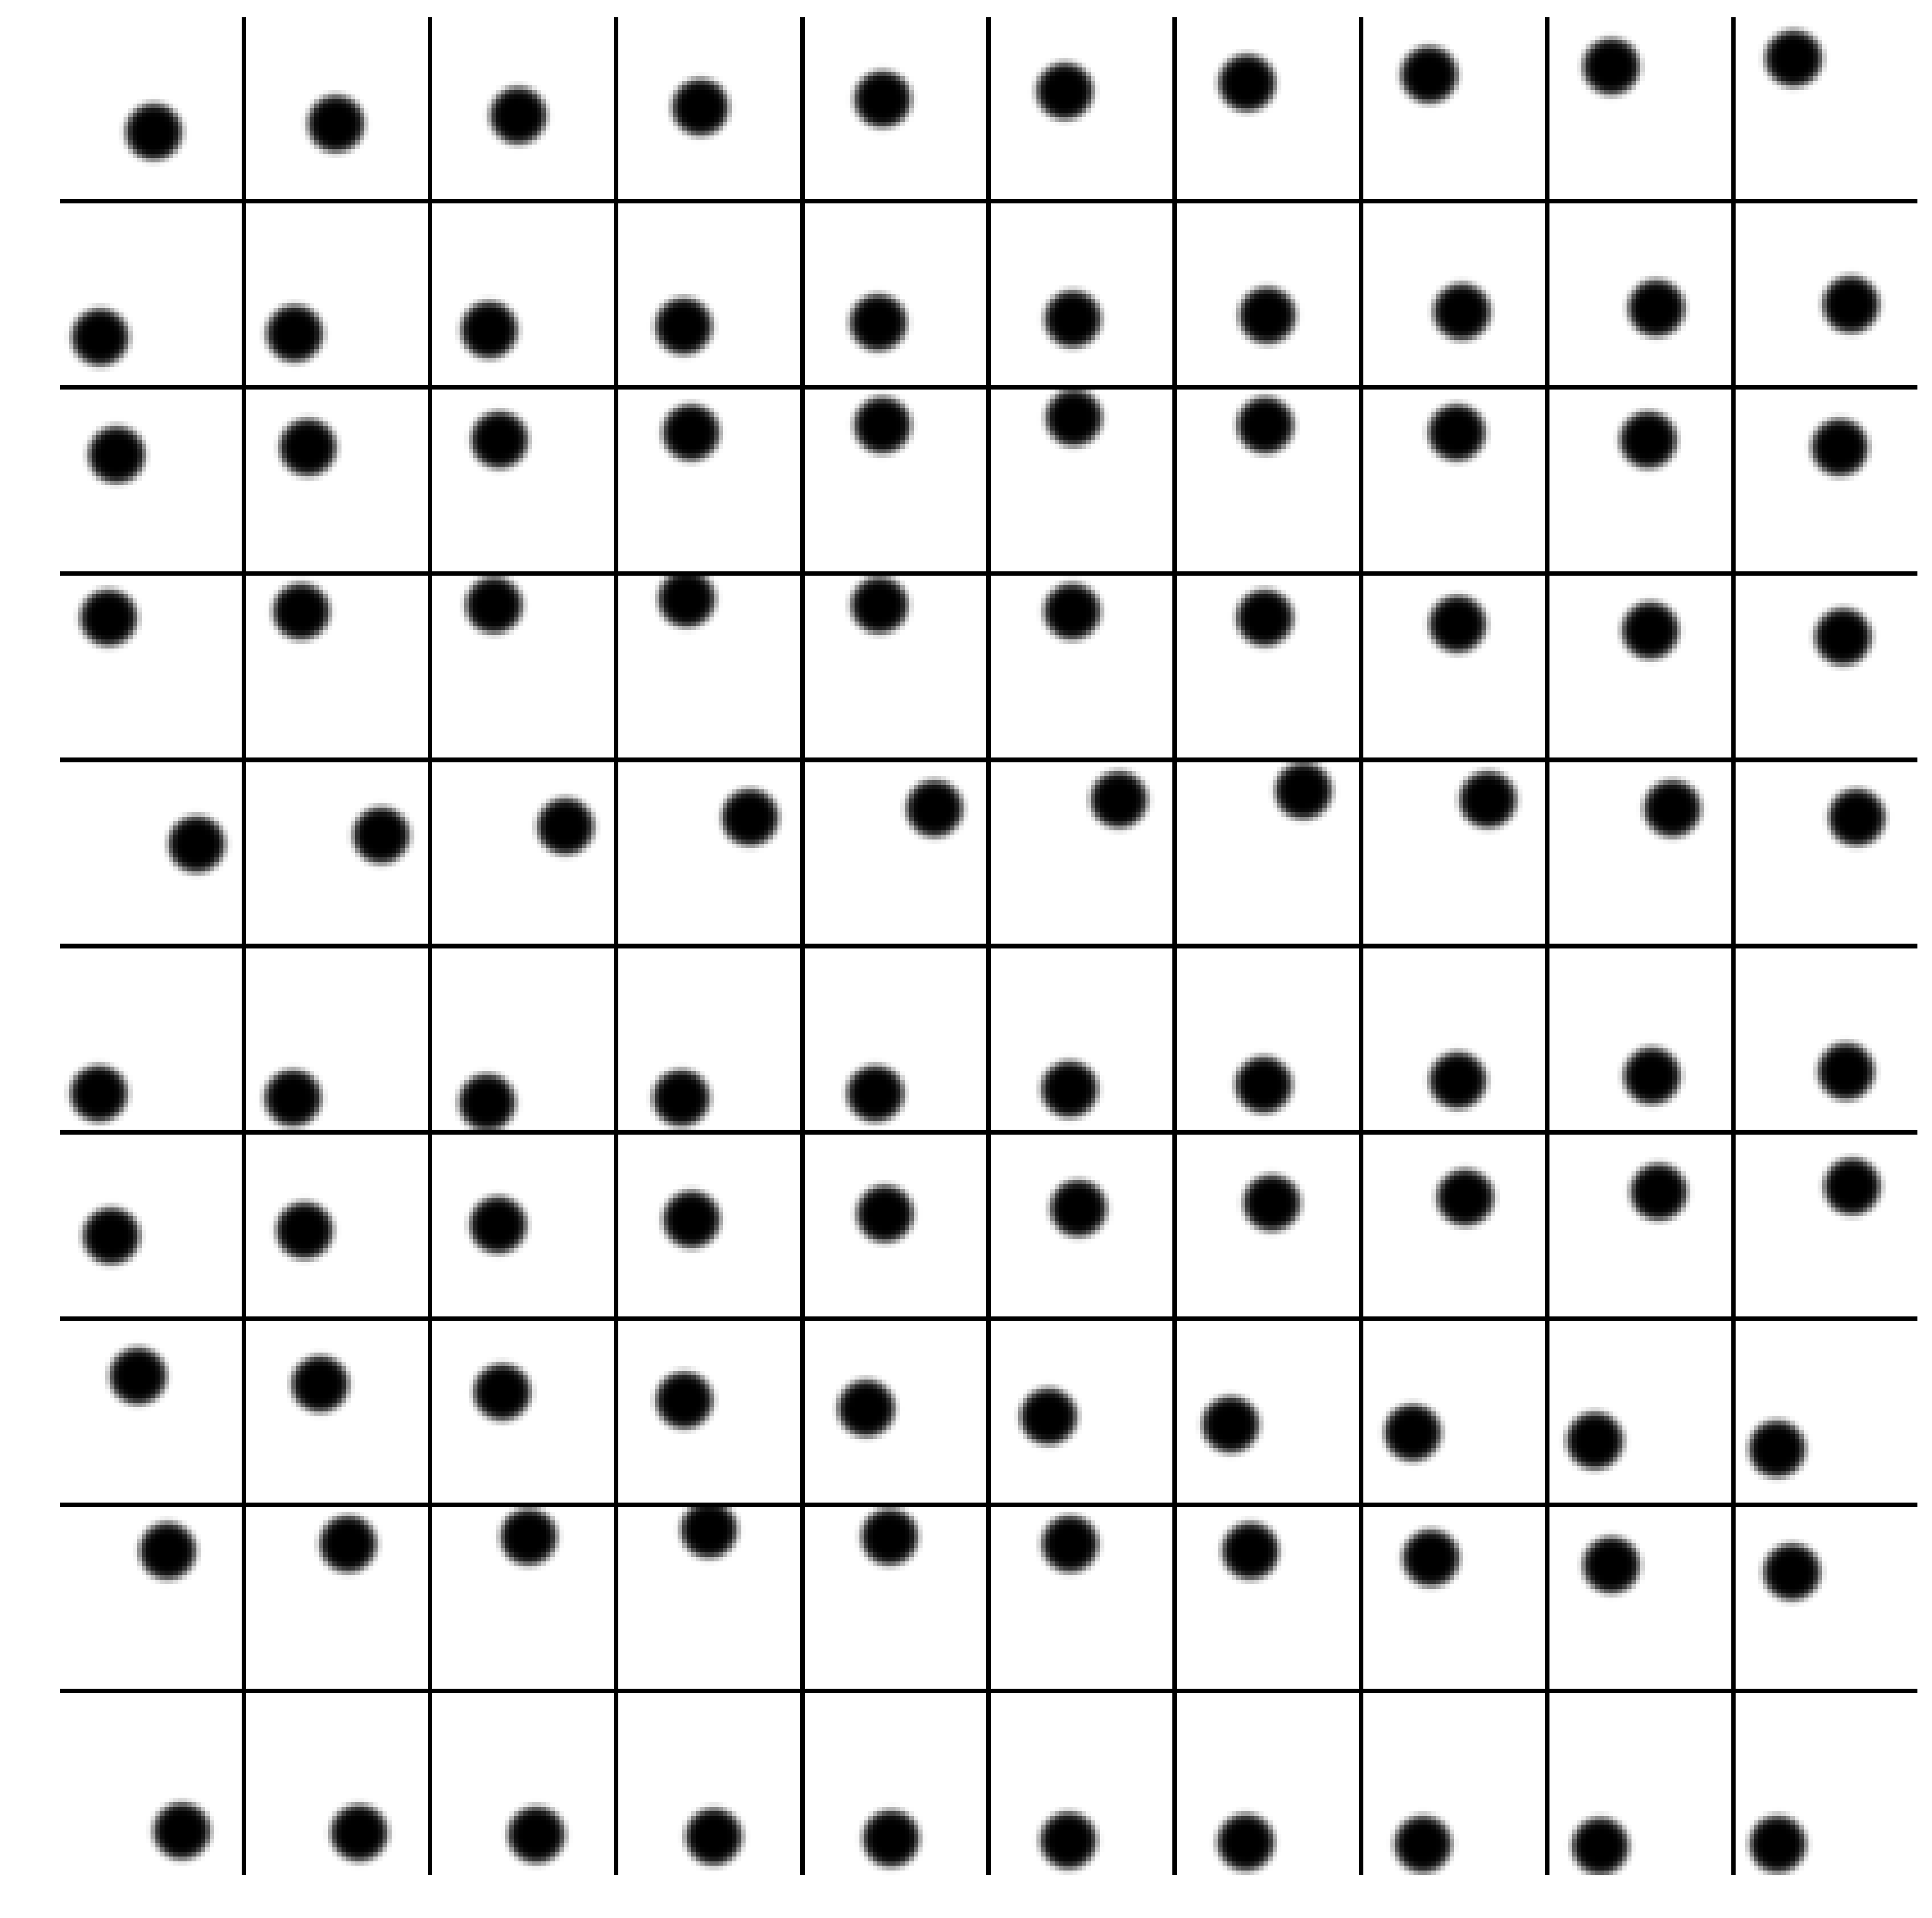

In [5]:
dataSet = generateSeq(10)
if type(dataSet) is tuple:
    if(len(dataSet)==2):
        dataSet,ds_target = dataSet
    elif (len(dataSet)==3):
        dataSet,ds_target,regY = dataSet
    print(ds_target.shape)
    
dataSet = gaussian_noise(torch.from_numpy(dataSet),True,0).numpy()
showSeq(False,-1,"initailSeq",dataSet[:,:,:,:,:],oneD=dimention==1,revert=True)
f0=np.copy(dataSet[0,:,:,0])
f1=np.copy(dataSet[1,:,:,0])
f2=np.copy(dataSet[2,:,:,0])
dsBackup=np.copy(dataSet)


In [6]:
save_code_backup()
if InfrencePhase:
    paintEvery=50
else:
    paintEvery=300

EPS=0.00000001
if InfrencePhase:
    bs=100
else:
    bs=1000

if InfrencePhase:
    runs=10000/bs
else:
    runs=2000000

inS = input_size

class TransFFTAttention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1= torch.nn.Conv2d(1,4,kernel_size=1)
        self.bn1=torch.nn.BatchNorm2d(4)
        self.pool= torch.nn.MaxPool2d(kernel_size=(2,2))
        self.conv2= torch.nn.Conv2d(4,2,kernel_size=3)
        self.bn2=torch.nn.BatchNorm2d(2)
        self.relu1=torch.nn.PReLU(num_parameters=1,init=0.2)
        self.relu2=torch.nn.PReLU(num_parameters=1,init=0.2)
        self.fc1 = torch.nn.Linear(648,4,bias=True)
        self.soft = torch.nn.Softmax(dim=1)
        self.locationBias=torch.nn.Parameter(torch.zeros(1,1,40,40))
    def forward(self,x):
        xx=x+self.locationBias
#         x=torch.cat((x,self.locationBias.expand(x.shape[0],1,40,40)),dim=1)
        convRes=self.relu2(self.bn2(self.conv2(self.pool(self.relu1(self.bn1(self.conv1(xx)))))))
#         print(convRes.shape)
        return self.soft(self.fc1(convRes.view(-1,648)))

class BiasRes(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,1,bias=False)
        self.fc1.weight.data[0,:]=torch.tensor([1, 1.15, 1.15, 1.25])
        
    def forward(self,x):
        return self.fc1(x)
    
class PrepareRes(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1,10,kernel_size=21,padding=0)
        self.bn1=torch.nn.BatchNorm2d(10)
        self.relu1=torch.nn.Sigmoid()
        self.conv2 = torch.nn.Conv2d(10,4,kernel_size=19,padding=0)
        self.bn2=torch.nn.BatchNorm2d(4)
        self.relu2=torch.nn.Sigmoid()
        self.conv3 = torch.nn.Conv2d(4,1,kernel_size=2,padding=0)
        
    def forward(self,x):
        res=self.conv3(self.relu2(self.bn2(self.conv2(self.relu1(self.bn1(self.conv1(x)))))))
        return res*x

    
net2 = TransFFTAttention().to(avDev)
# net4 = BiasRes().to(avDev)
net4 = PrepareRes().to(avDev)


if InfrencePhase:
    modelNameToLoad="BestConvFFTBBall.th"
else:
    modelNameToLoad=".th"
shouldLoadModel=True
loadIt = None
if os.path.exists(modelNameToLoad) and shouldLoadModel:
    try:
        loadIt = torch.load(modelNameToLoad)
        optimizers = loadIt["optimizers"]
        net4.load_state_dict(loadIt["net4"])
        net2.load_state_dict(loadIt["net2"])
#         net.load_state_dict(loadIt["net"])
    except:
        print("Some error happend while loading")

# net2ParamsMinusLocB=dict(net2.named_parameters())
# del net2ParamsMinusLocB["locationBias"]
# net2ParamsMinusLocB=net2ParamsMinusLocB.values()
        
optimizers= [torch.optim.Adam(
    [
# {'params': net.parameters(),"name":"DenoiseFFT"},
{'params': net2.parameters(),"name":"TransFFTAttention"},
# {'params': net2ParamsMinusLocB,"name":"TransFFTAttention"},
# {'params': net2.locationBias,"name":"locationBias","weight_decay":0.01},
{'params': net4.parameters(), "name":"BiasRes",'lr': 0.001}
]
,lr=1e-03,betas=(0.9, 0.999),weight_decay=0.0000000)]


critBCE = torch.nn.BCELoss().to(avDev)
critBCELogit = torch.nn.BCEWithLogitsLoss().to(avDev)
critL1 = torch.nn.L1Loss().to(avDev)
critL2 = torch.nn.MSELoss().to(avDev)

def set_pg(op,newPg):
    for i,_ in enumerate(op):
        for pIndex,param_group in enumerate(op[i].param_groups):
            for p in param_group:
                currGL="layer"+str(i)+"_"+"paramGroup"+str(pIndex)
                if p in newPg[currGL]:
                    param_group[p] = newPg[currGL][p]
         
        
def get_pg(op):
    ret = dict()
    for i,_ in enumerate(op):
        for pIndex,param_group in enumerate(op[i].param_groups):
            currGL="layer"+str(i)+"_"+"paramGroup"+str(pIndex)
            ret[currGL]=dict()
            for p in param_group:
                if p!="params":
                    ret[currGL][p]=param_group[p]
    return ret
    



def addToParams(varName,setFunc="",getFunc=""):
    global params
    params[varName if setFunc=="" else setFunc+","+varName]=eval(varName) if getFunc=="" else eval(getFunc+"("+varName+")")
    
params = {}
addToParams("optimizers","set_pg","get_pg")
addToParams("runs")
addToParams("paintEvery")

paramCounter=0
with open(backupPath+"/params.json","w") as fi:
    json.dump(params,fi,indent=4)
paramsStat=os.stat(backupPath+"/params.json")[8]

def checkParamChange():
    global paramCounter,params,paramsStat
    newStat=os.stat(backupPath+"/params.json")[8]
    if paramsStat!=newStat:
        paramsStat=newStat
        print("Params Changed")
        with open(backupPath+"/"+str(paramCounter)+".json","w") as fd:
            json.dump(params,fd,indent=4)
        with open(backupPath+"/params.json","r") as fi:
            params=json.load(fi)
        paramCounter+=1
        print(params)
        for p in params:
            if("," in p):#function
                ar=p.split(',')
                exec(ar[0]+"("+ar[1]+","+str(params[p])+")")
            else:
                exec("global "+p+";"+p+"="+str(params[p]))

                
def modelAccess(model):
#     if(len(cuda_devices)>0):
#         return model.module
    return model
def save_model(added=""):
    global net
    global net2
    global net4
    global optimizers

    
    saveIt = {
#       'net': modelAccess(net).state_dict(),
      'net2': modelAccess(net2).state_dict(),
      'net4': modelAccess(net4).state_dict(),
      'optimizers': optimizers
    }

    strSave=str(datetime.datetime.now())+added
    torch.save(saveIt, strSave+".th")
    print("Model saved ",strSave+".th")
    
t=0

0 bceMin= 0.03640  bceNetFull= 0.00063  bceNet= 0.04109  L1Net= 0.00603  L2Net= 0.00063
| L2Net:   0.000634 |
Number of Parameters =  23201
0
locationBias(N)(r)  torch.Size([1, 1, 40, 40, 1])


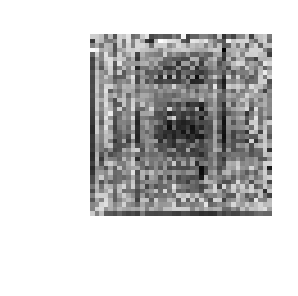

hf0(N)(r)  (5, 2, 40, 40, 1)


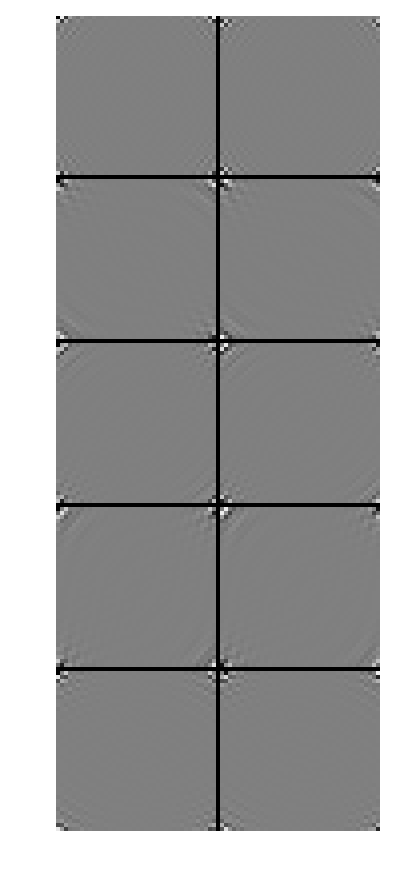

hf1(N)(r)  (5, 2, 40, 40, 1)


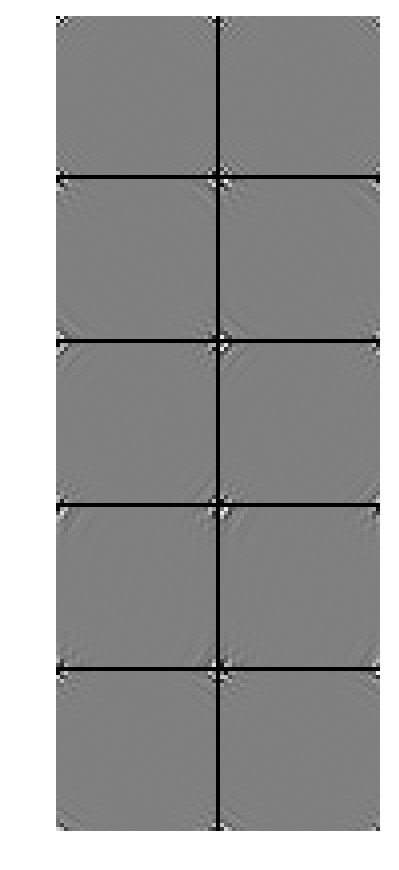

hf2(N)(r)  (5, 2, 40, 40, 1)


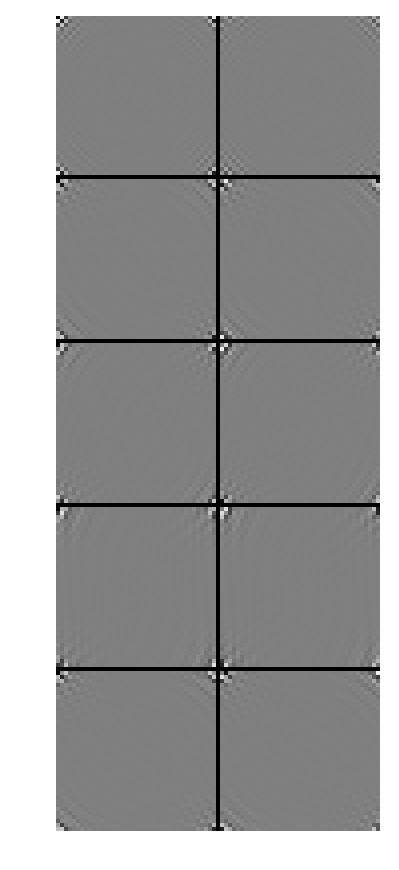

hfRel1Orig(N)(r)  (5, 2, 40, 40, 1)


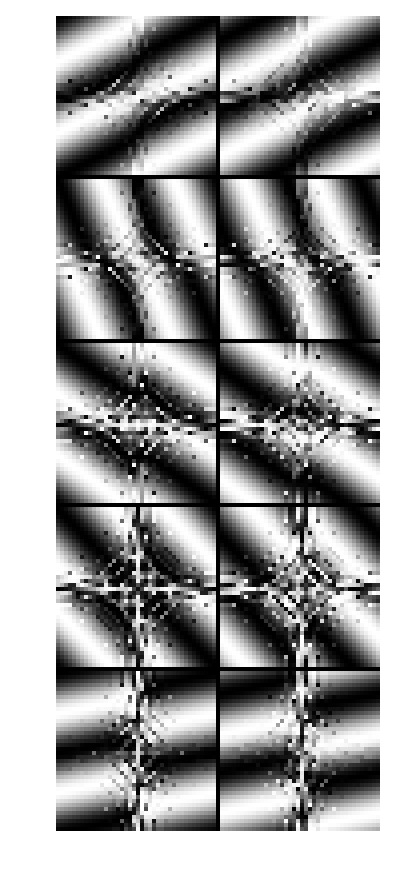

GT,Net,Blind(r)  (5, 10, 124, 40, 1)


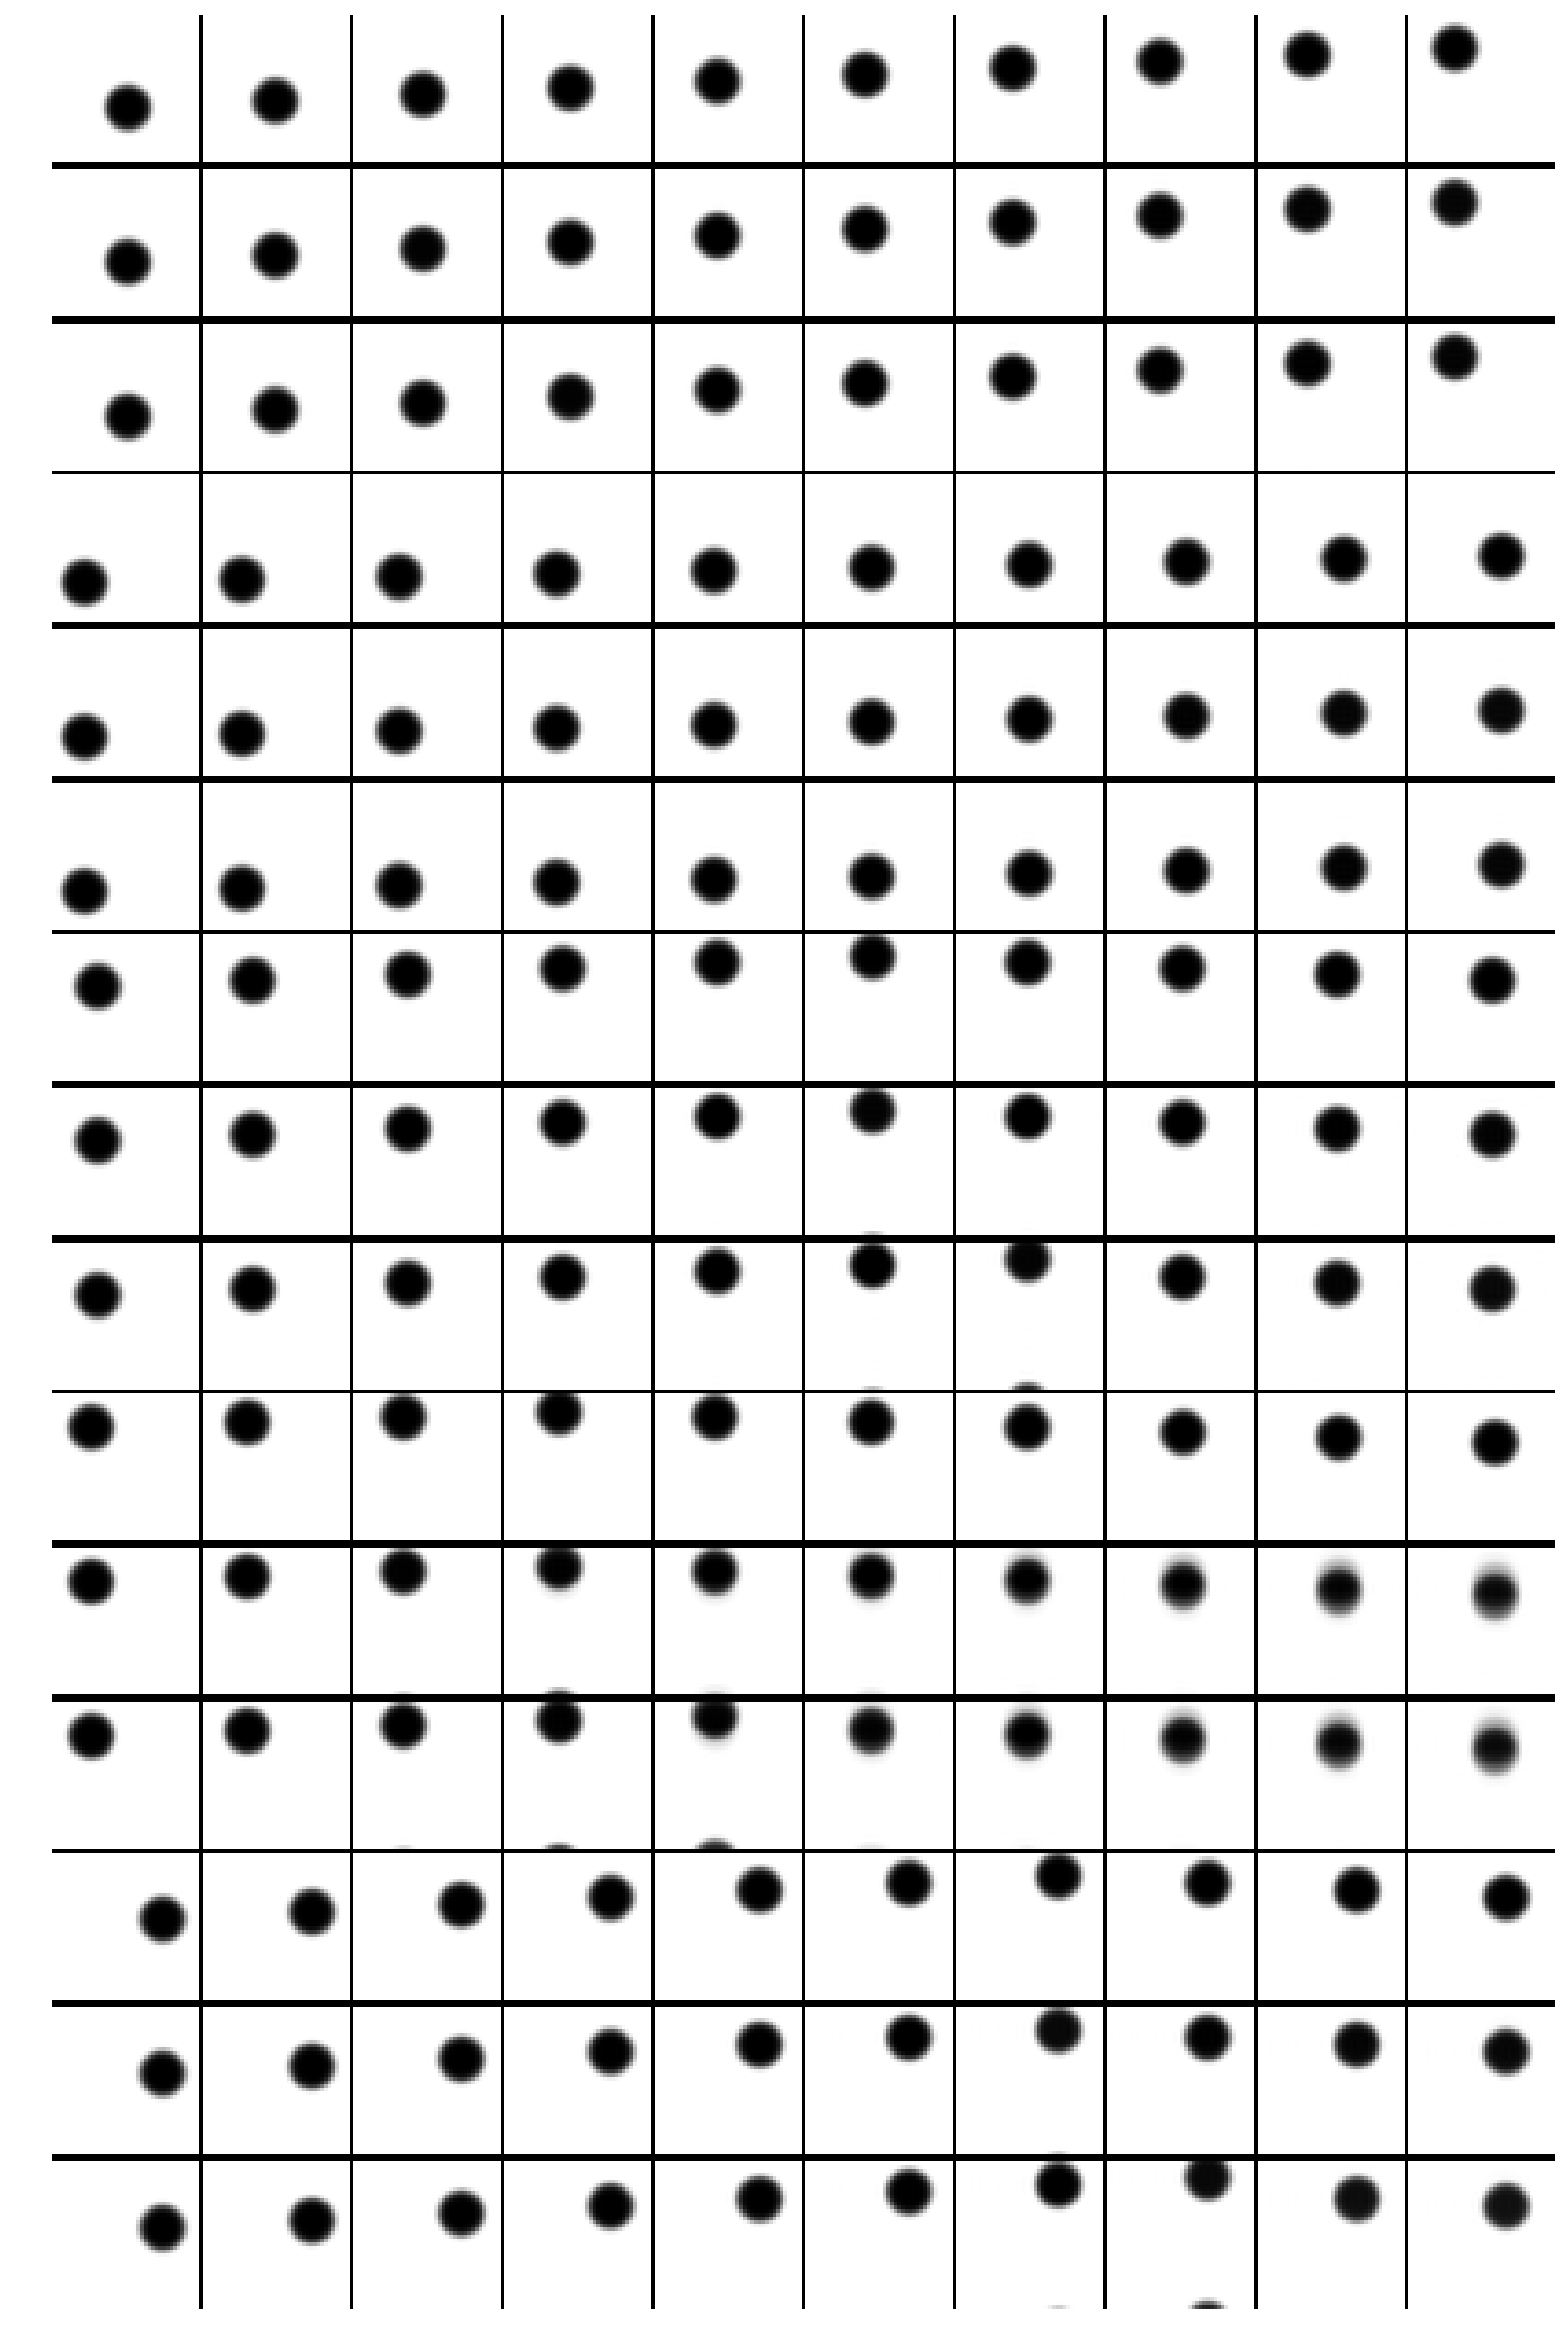

diffNet(N)(r)  (5, 8, 40, 40, 1)


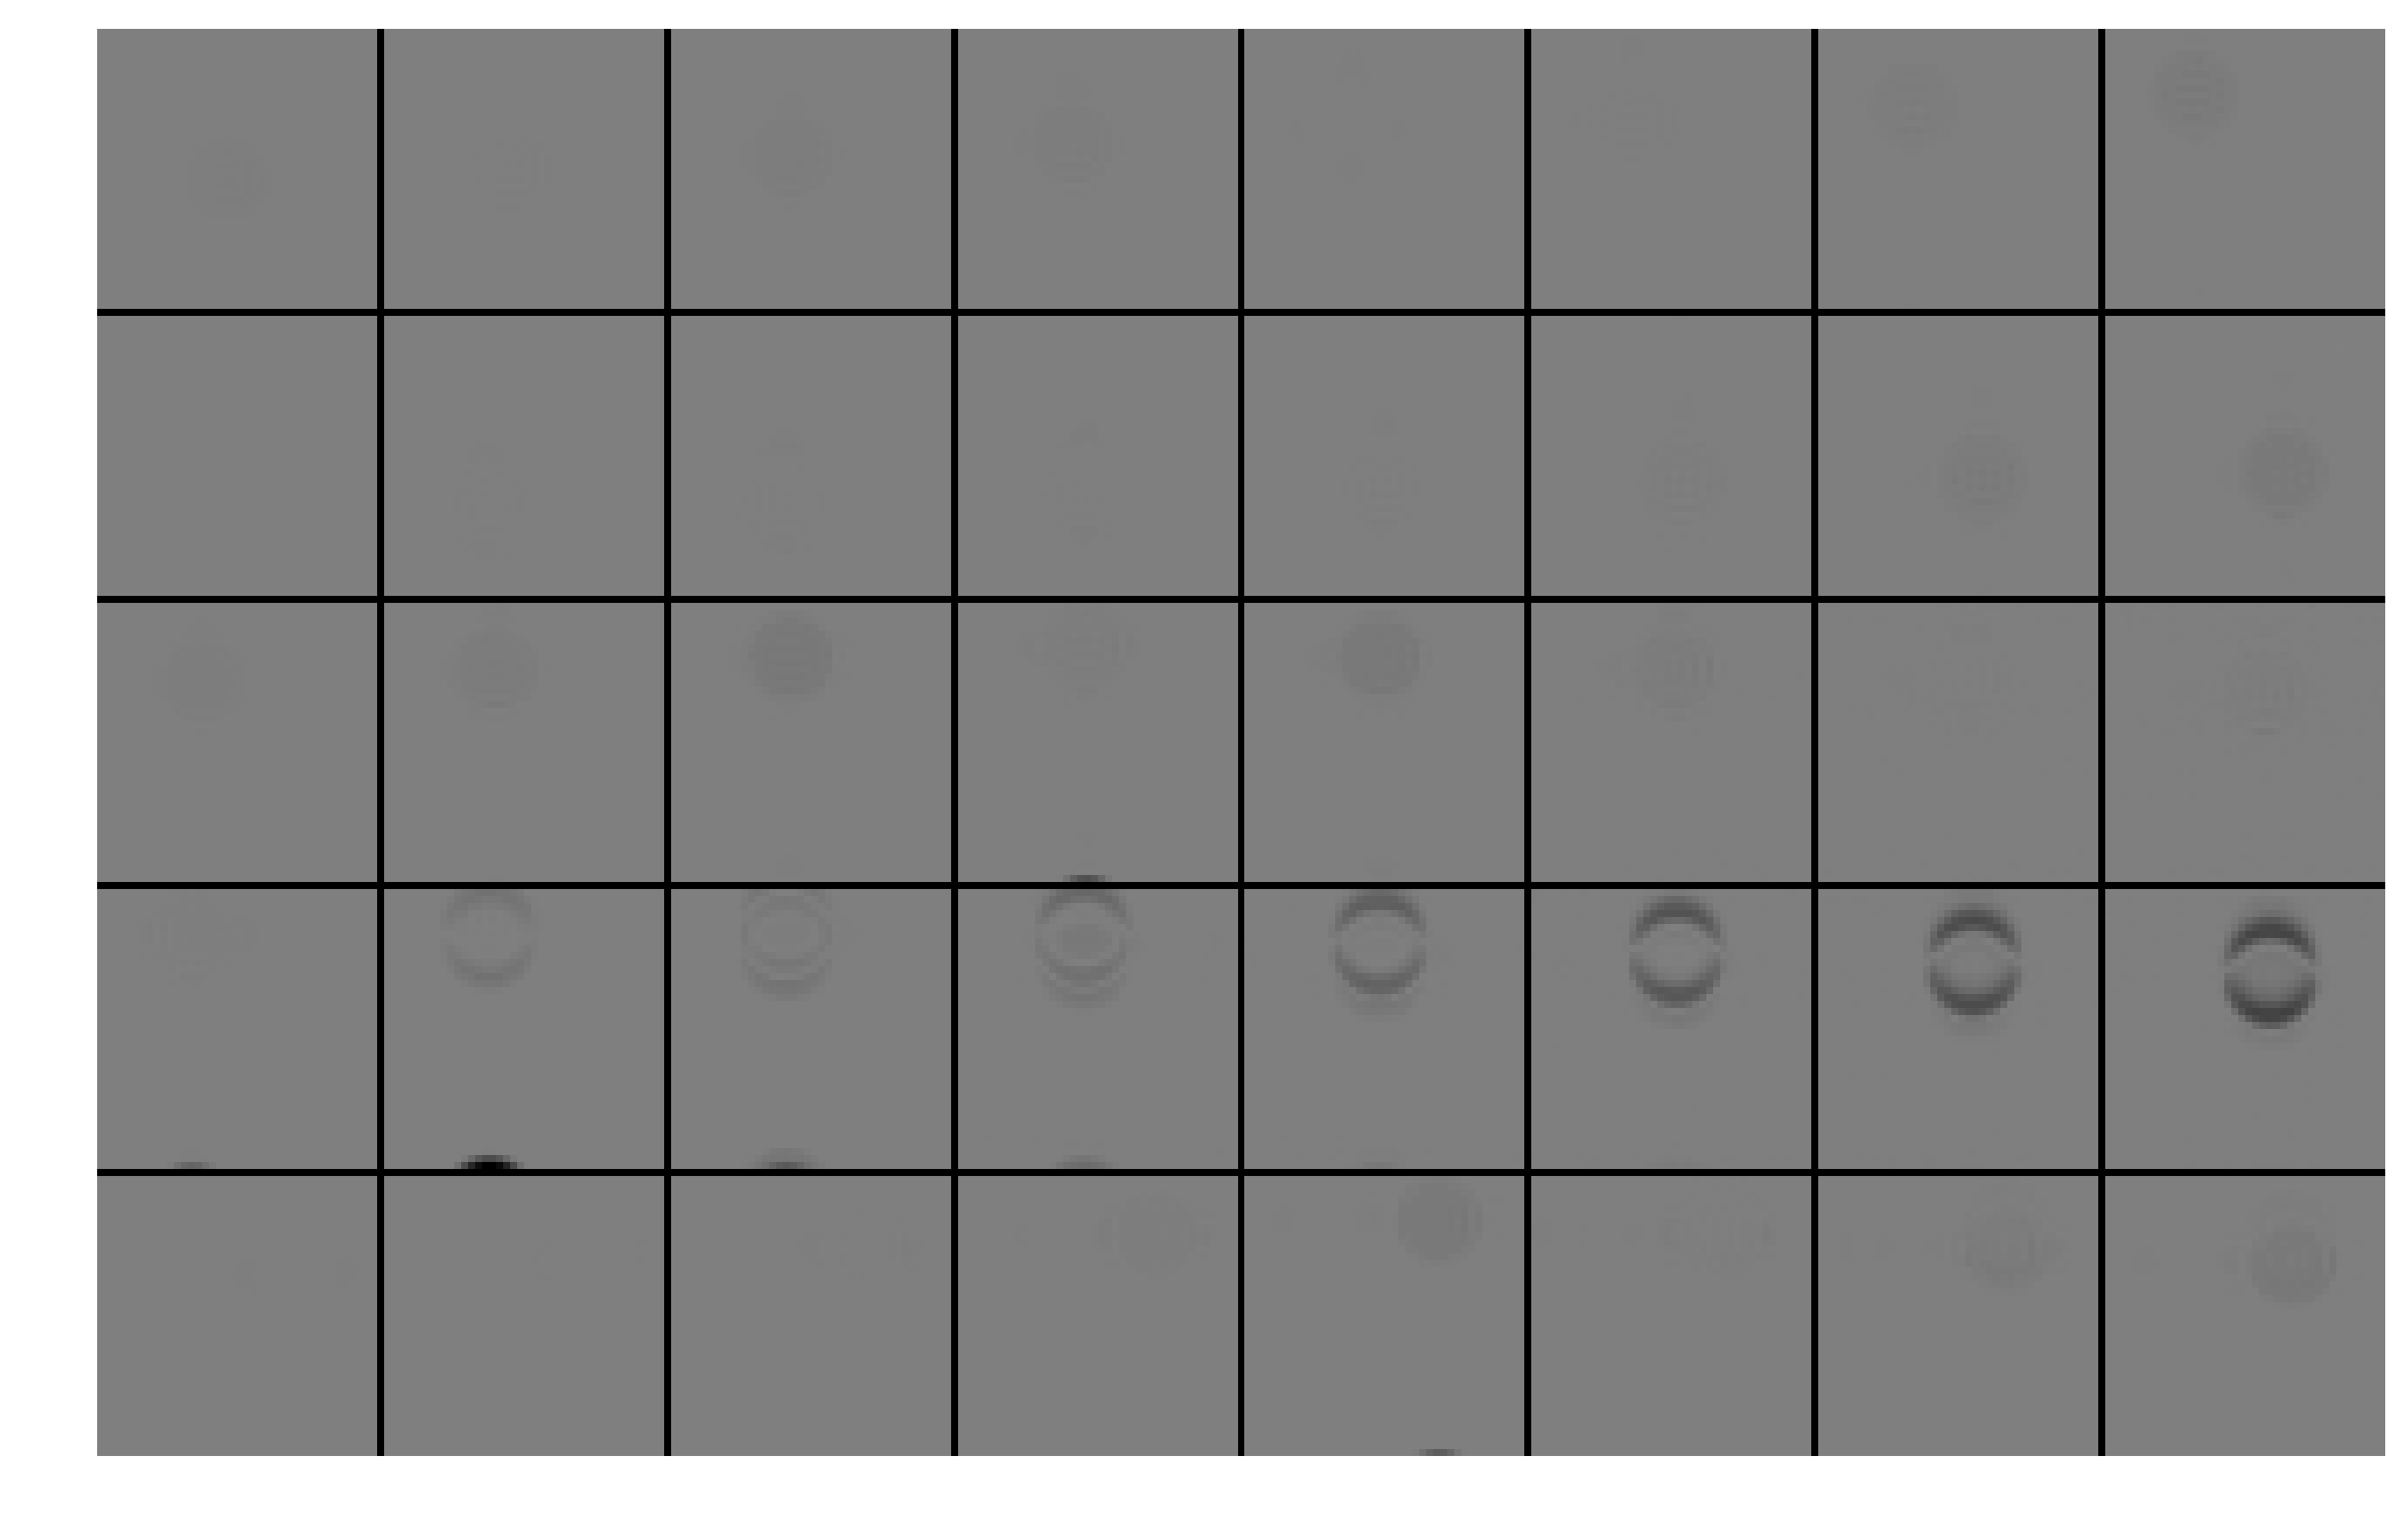

1 bceMin= 0.03643  bceNetFull= 0.00086  bceNet= 0.04294  L1Net= 0.00922  L2Net= 0.00086
| L2Net:   0.000858 |
2 bceMin= 0.03635  bceNetFull= 0.00060  bceNet= 0.04111  L1Net= 0.00544  L2Net= 0.00060
3 bceMin= 0.03636  bceNetFull= 0.00081  bceNet= 0.04123  L1Net= 0.00596  L2Net= 0.00081
4 bceMin= 0.03639  bceNetFull= 0.00079  bceNet= 0.04206  L1Net= 0.00643  L2Net= 0.00079
5 bceMin= 0.03635  bceNetFull= 0.00111  bceNet= 0.04284  L1Net= 0.00925  L2Net= 0.00111
| L2Net:   0.001112 |
6 bceMin= 0.03647  bceNetFull= 0.00081  bceNet= 0.04212  L1Net= 0.00754  L2Net= 0.00081
7 bceMin= 0.03634  bceNetFull= 0.00065  bceNet= 0.04118  L1Net= 0.00542  L2Net= 0.00065
8 bceMin= 0.03631  bceNetFull= 0.00090  bceNet= 0.04214  L1Net= 0.00659  L2Net= 0.00090
9 bceMin= 0.03641  bceNetFull= 0.00078  bceNet= 0.04184  L1Net= 0.00726  L2Net= 0.00078
| L2Net:   0.000780 |
10 bceMin= 0.03637  bceNetFull= 0.00091  bceNet= 0.04158  L1Net= 0.00598  L2Net= 0.00091
11 bceMin= 0.03637  bceNetFull= 0.00089  bceNet= 0.04

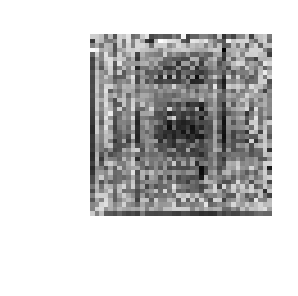

hf0(N)(r)  (5, 2, 40, 40, 1)


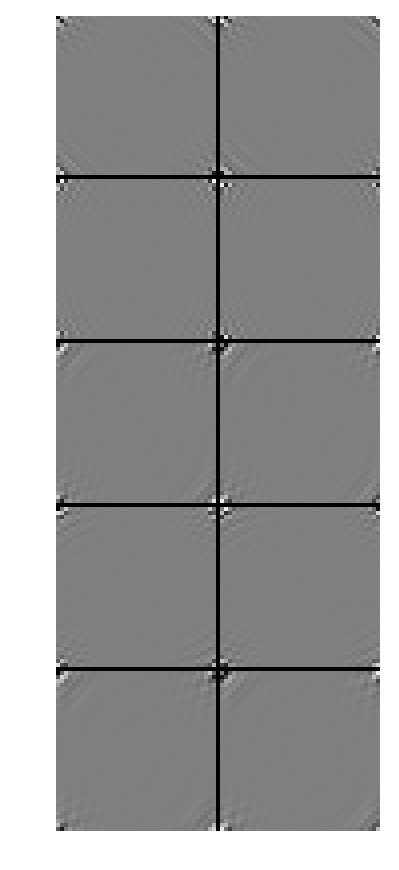

hf1(N)(r)  (5, 2, 40, 40, 1)


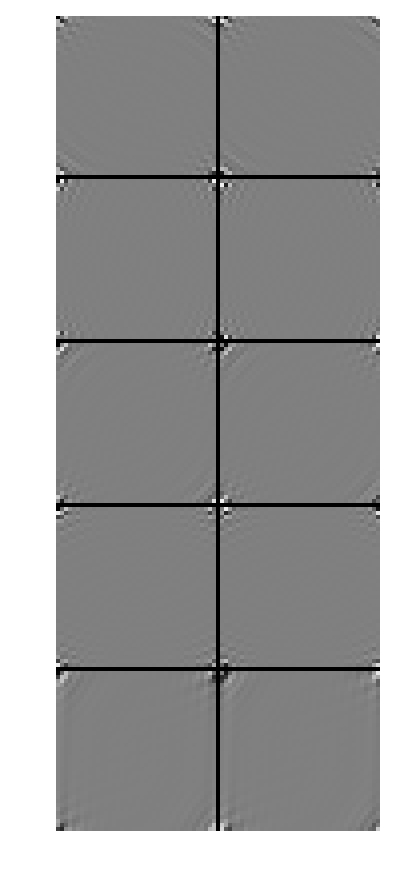

hf2(N)(r)  (5, 2, 40, 40, 1)


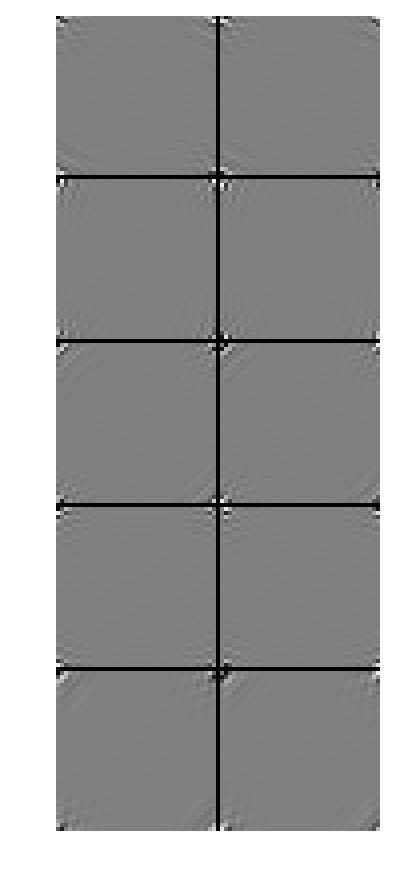

hfRel1Orig(N)(r)  (5, 2, 40, 40, 1)


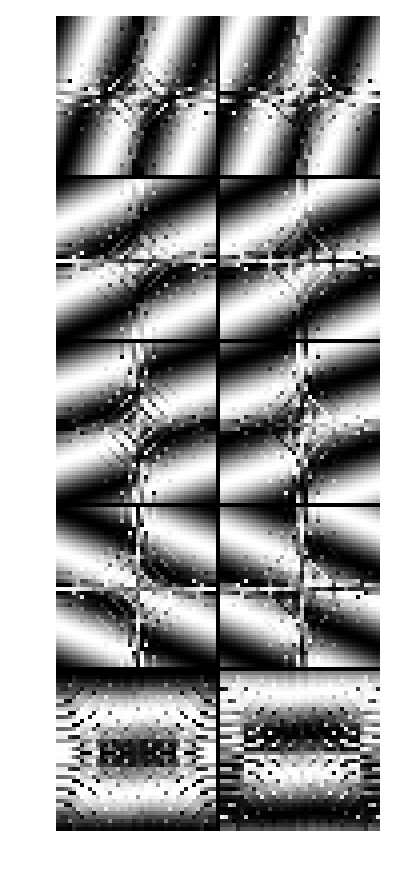

GT,Net,Blind(r)  (5, 10, 124, 40, 1)


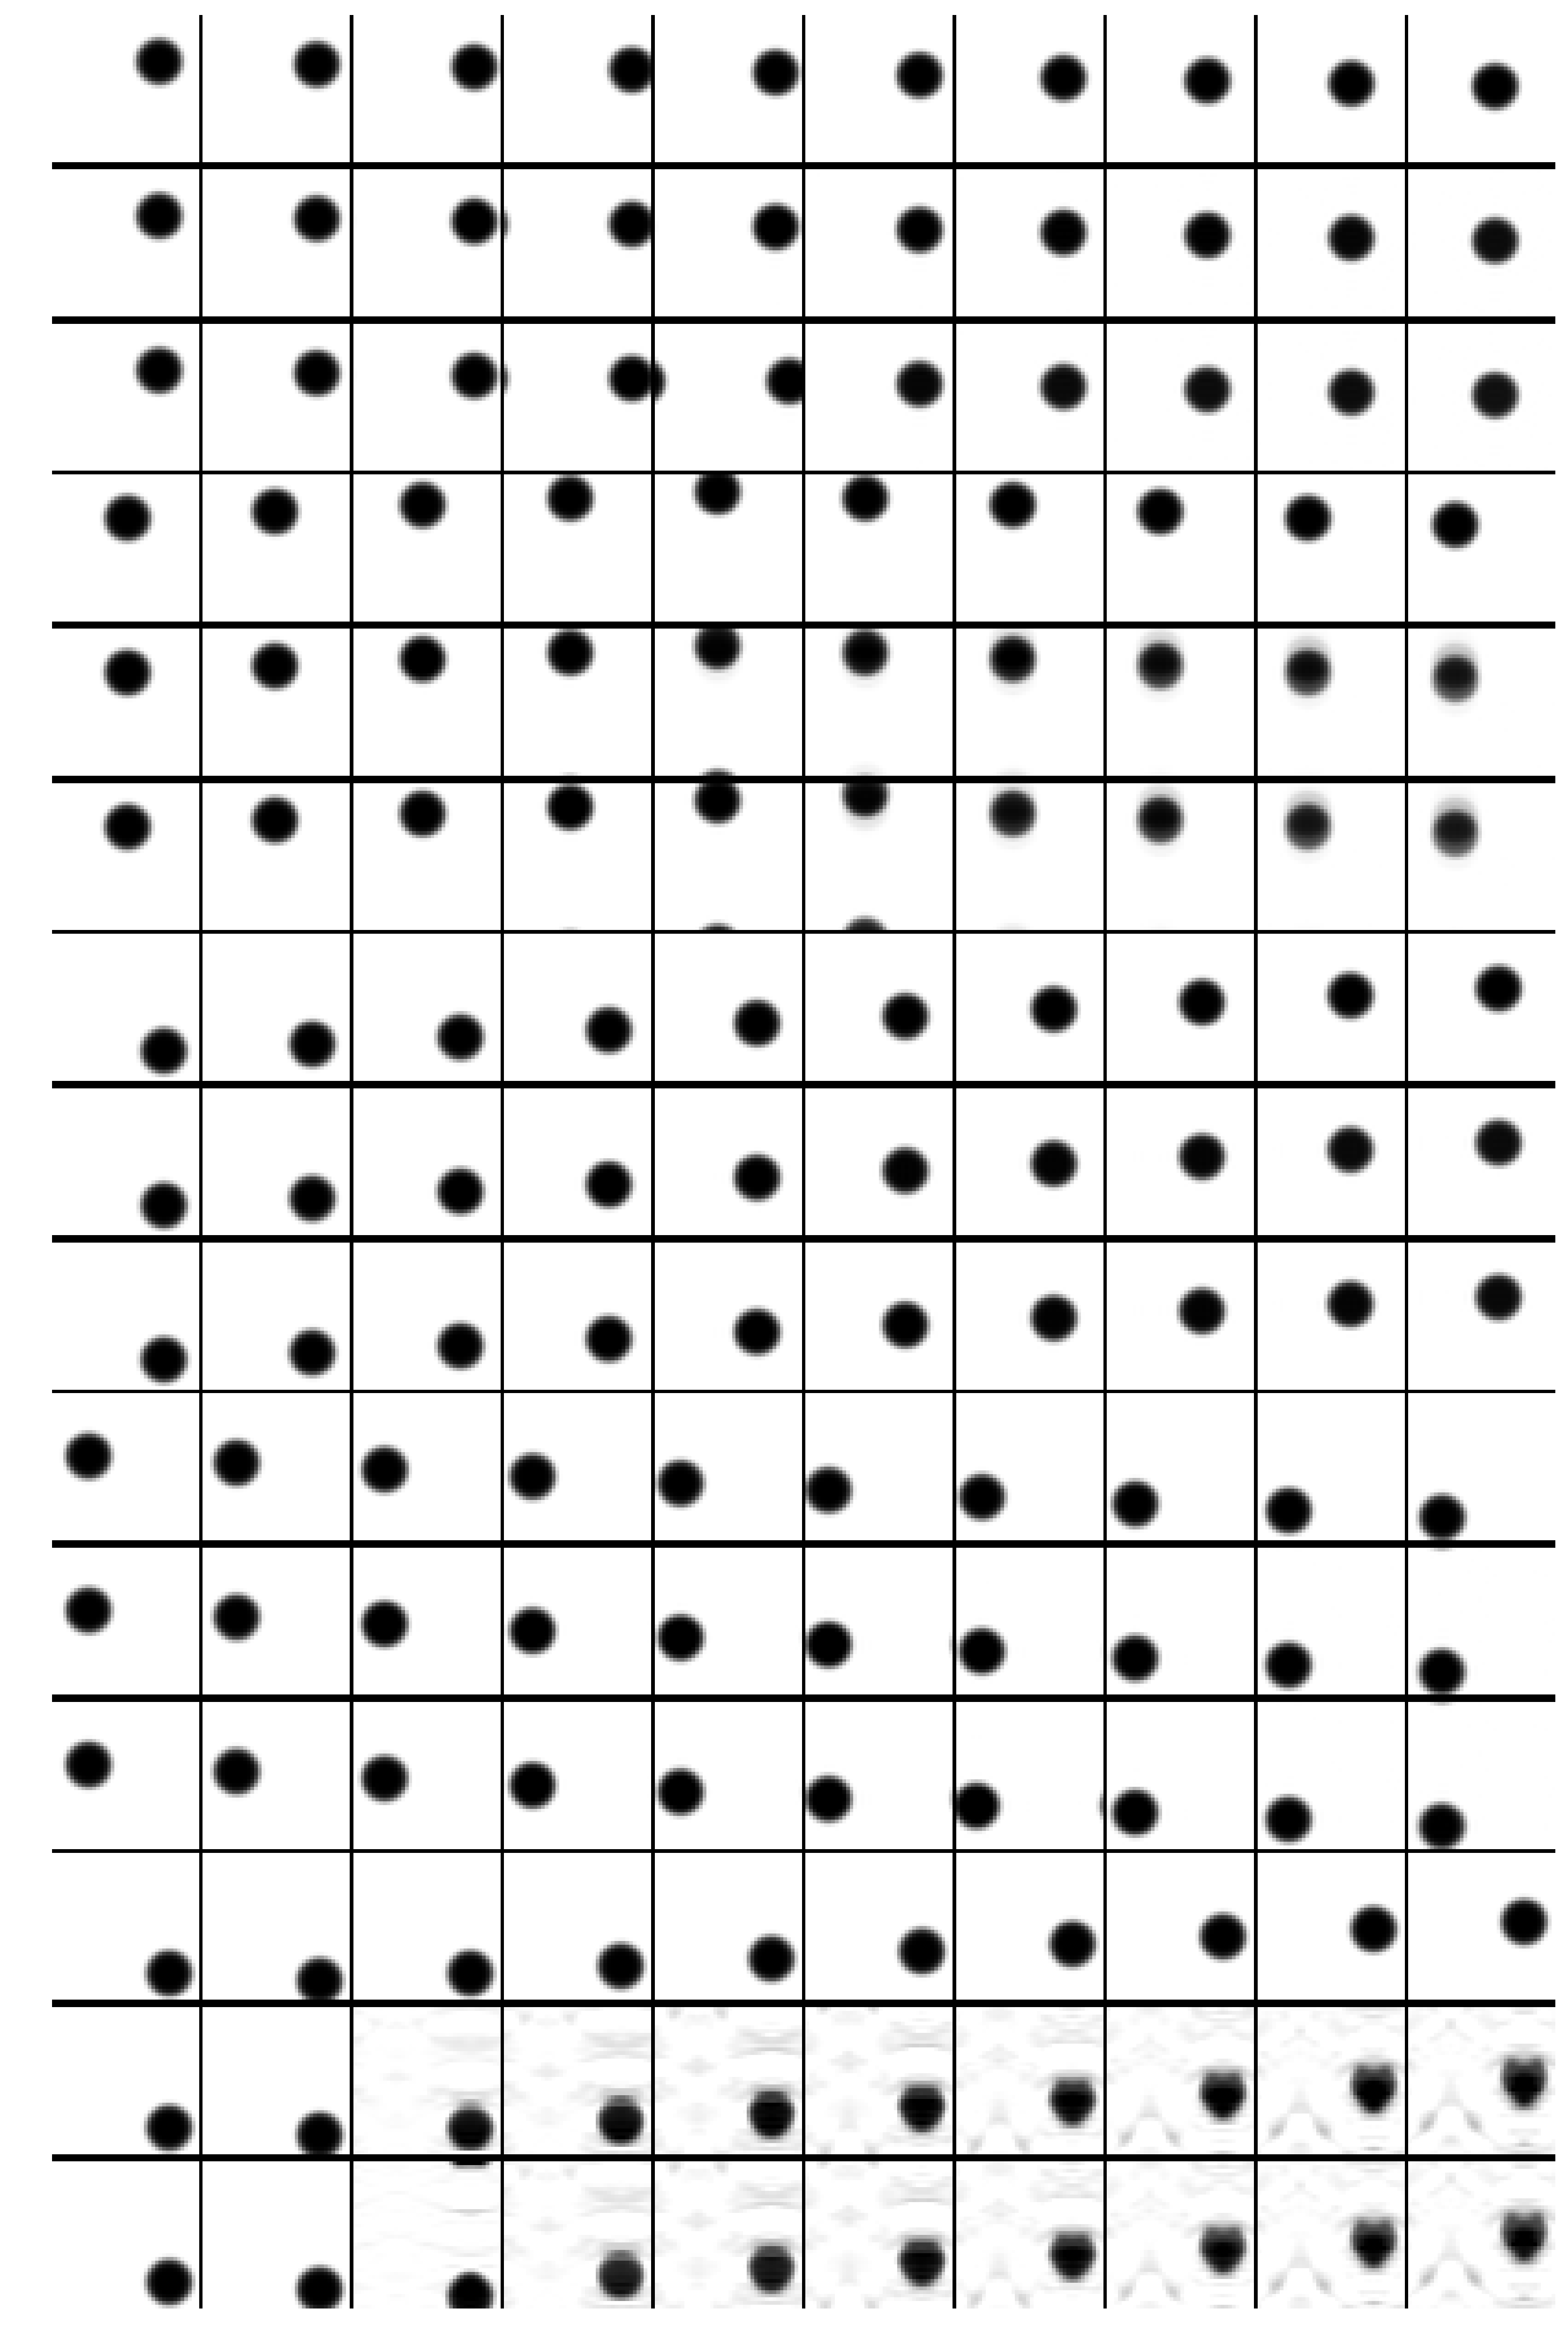

diffNet(N)(r)  (5, 8, 40, 40, 1)


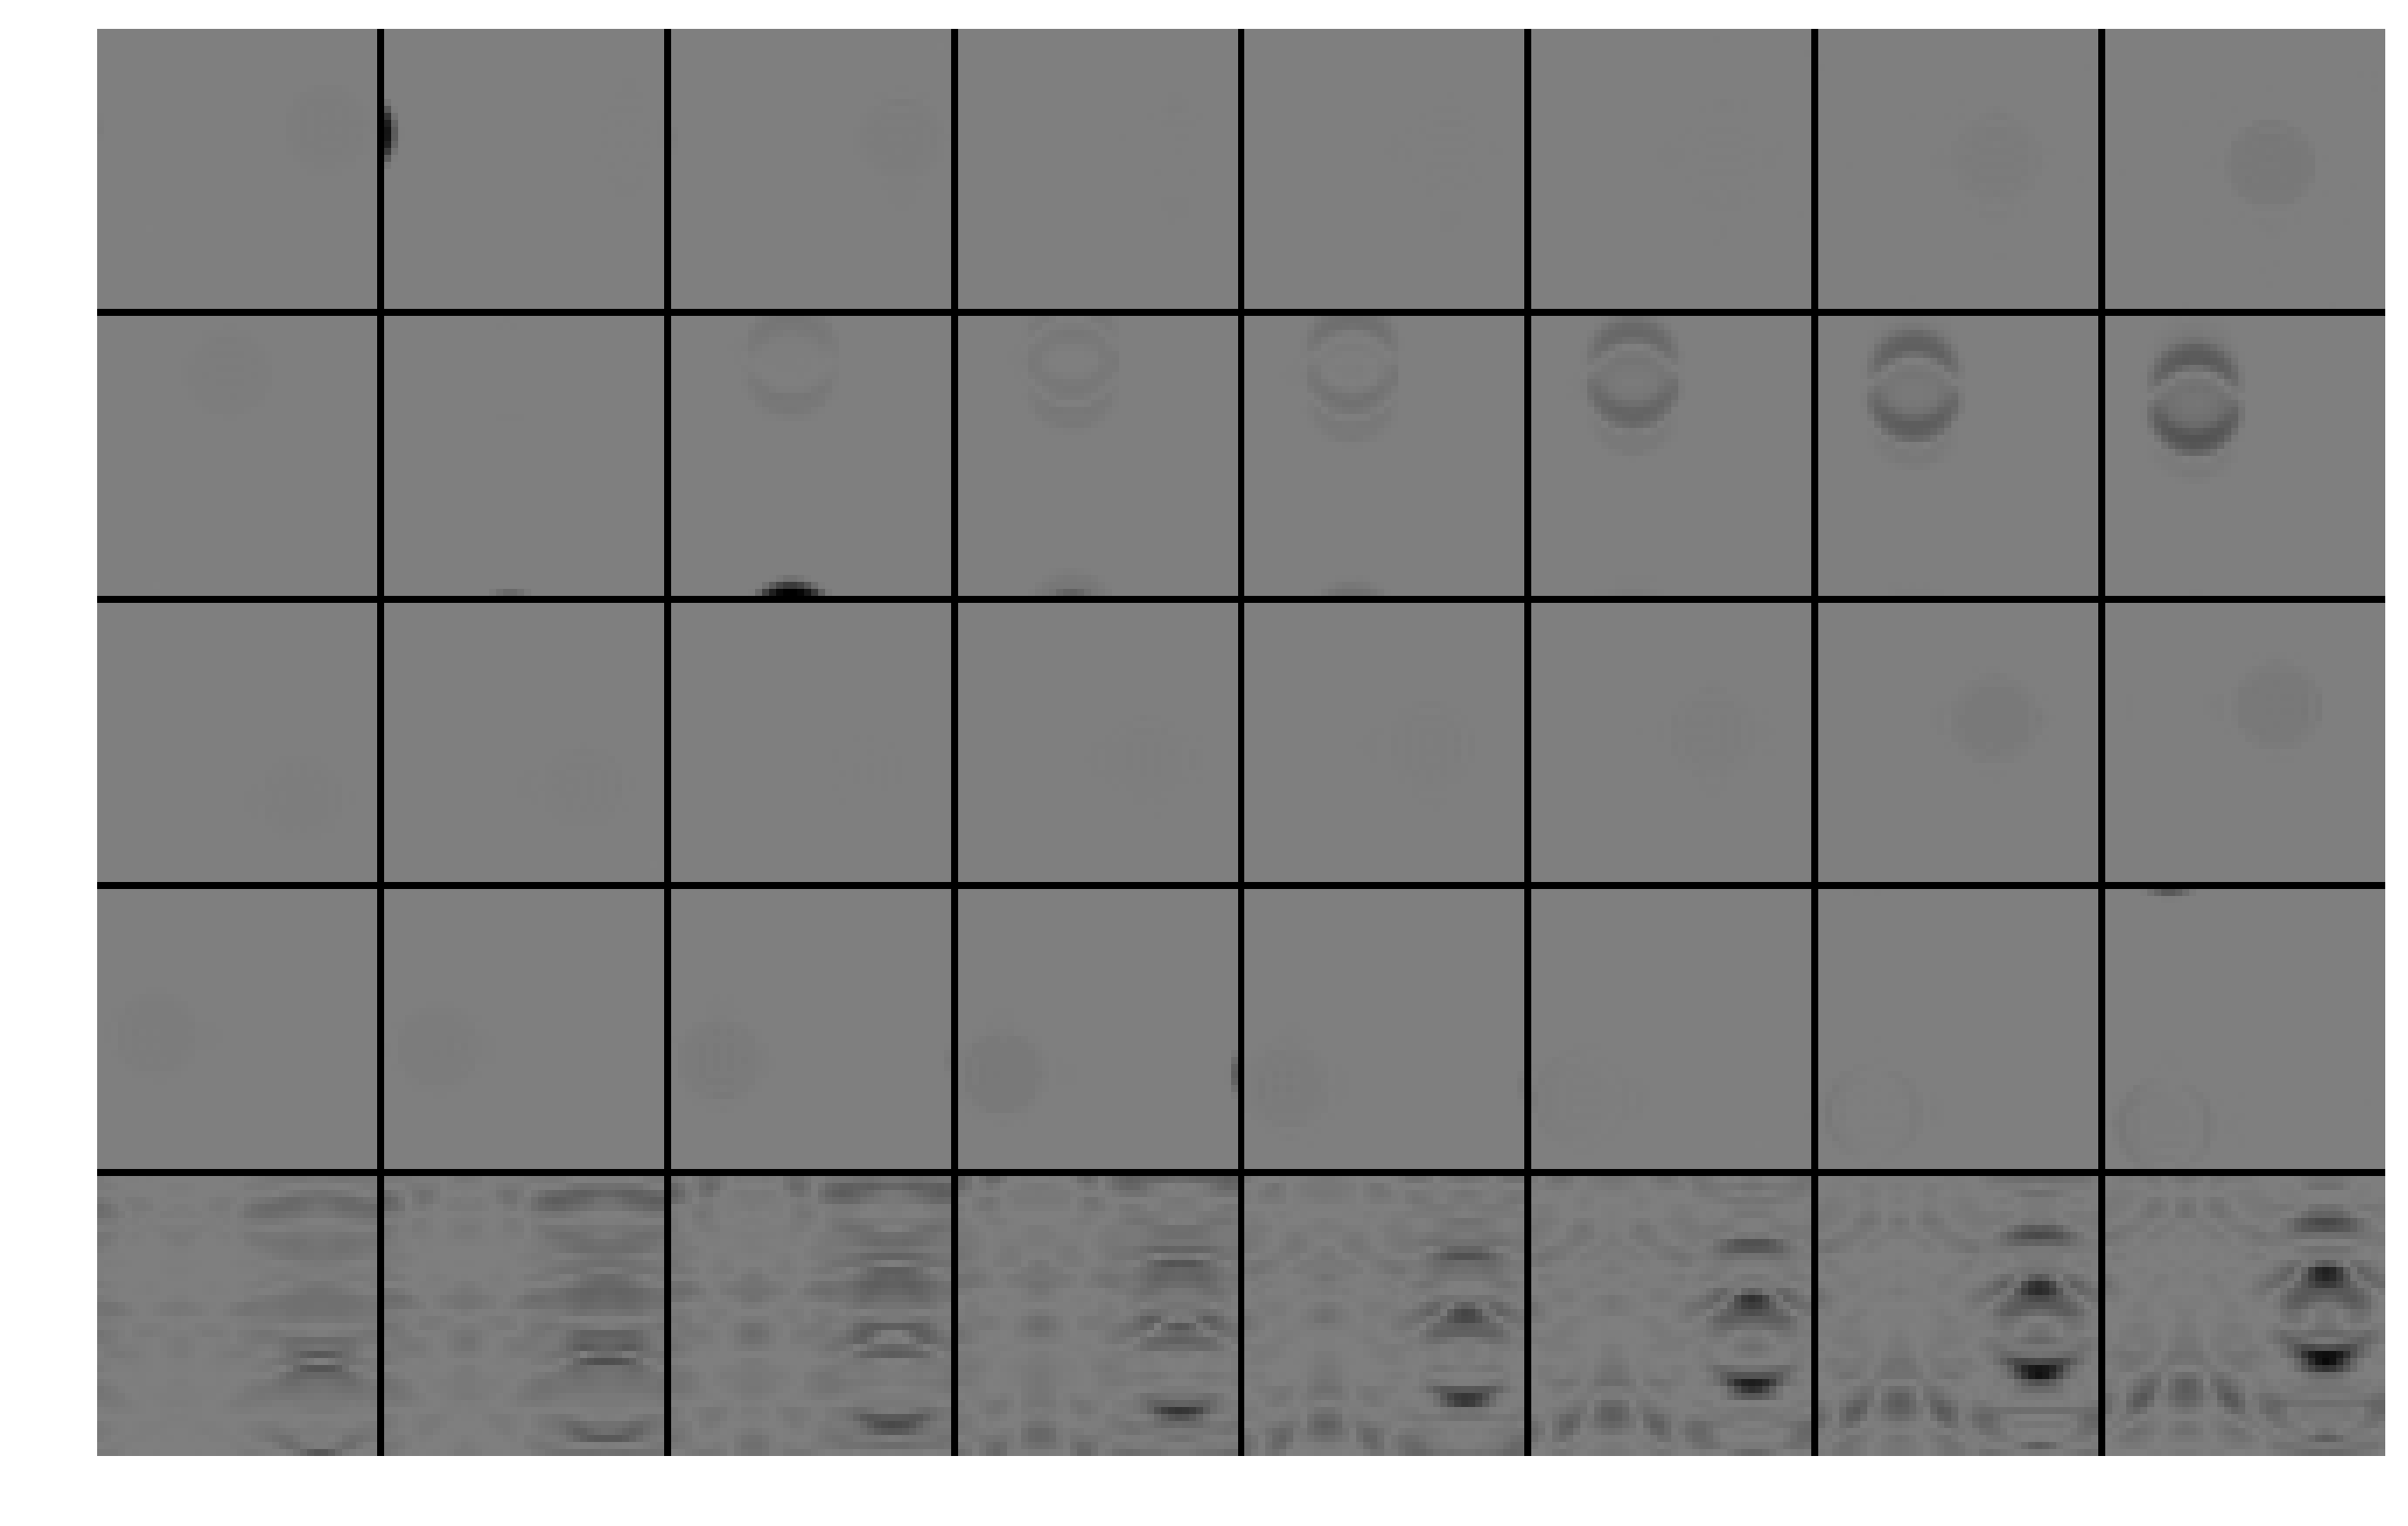

51 bceMin= 0.03638  bceNetFull= 0.00079  bceNet= 0.04238  L1Net= 0.00553  L2Net= 0.00079
| L2Net:   0.000792 |
52 bceMin= 0.03640  bceNetFull= 0.00052  bceNet= 0.04228  L1Net= 0.00651  L2Net= 0.00052
53 bceMin= 0.03641  bceNetFull= 0.00106  bceNet= 0.04316  L1Net= 0.00788  L2Net= 0.00106
54 bceMin= 0.03637  bceNetFull= 0.00091  bceNet= 0.04276  L1Net= 0.00743  L2Net= 0.00091
| L2Net:   0.000910 |
55 bceMin= 0.03639  bceNetFull= 0.00082  bceNet= 0.04162  L1Net= 0.00608  L2Net= 0.00082
56 bceMin= 0.03629  bceNetFull= 0.00131  bceNet= 0.04346  L1Net= 0.00851  L2Net= 0.00131
57 bceMin= 0.03639  bceNetFull= 0.00124  bceNet= 0.04413  L1Net= 0.00916  L2Net= 0.00124
| L2Net:   0.001239 |
58 bceMin= 0.03637  bceNetFull= 0.00088  bceNet= 0.04304  L1Net= 0.00716  L2Net= 0.00088
59 bceMin= 0.03627  bceNetFull= 0.00134  bceNet= 0.04316  L1Net= 0.00739  L2Net= 0.00134
60 bceMin= 0.03633  bceNetFull= 0.00051  bceNet= 0.04086  L1Net= 0.00466  L2Net= 0.00051
61 bceMin= 0.03632  bceNetFull= 0.00103  bce

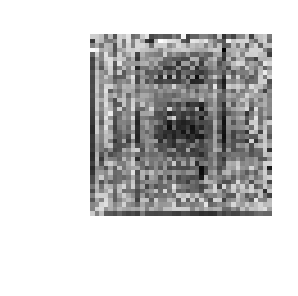

hf0(N)(r)  (5, 2, 40, 40, 1)


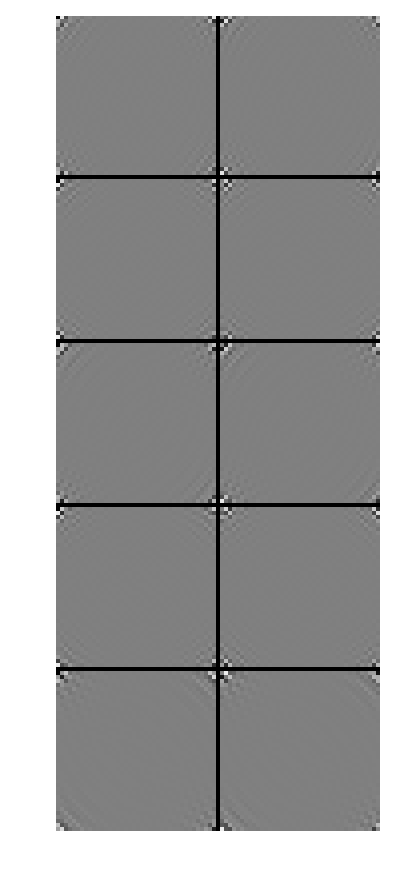

hf1(N)(r)  (5, 2, 40, 40, 1)


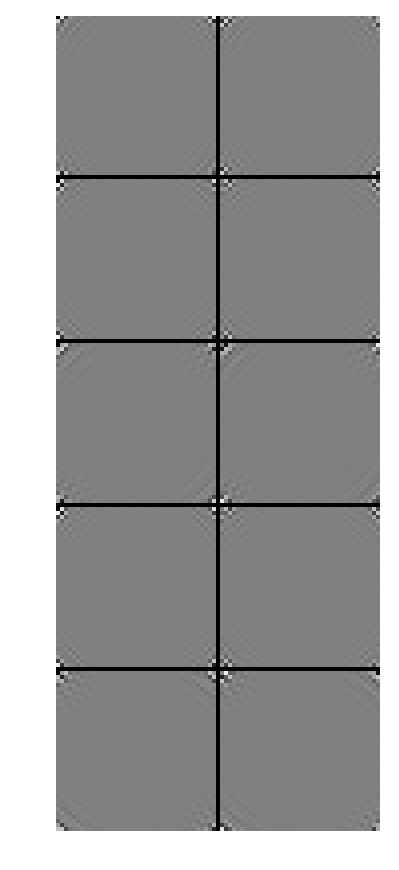

hf2(N)(r)  (5, 2, 40, 40, 1)


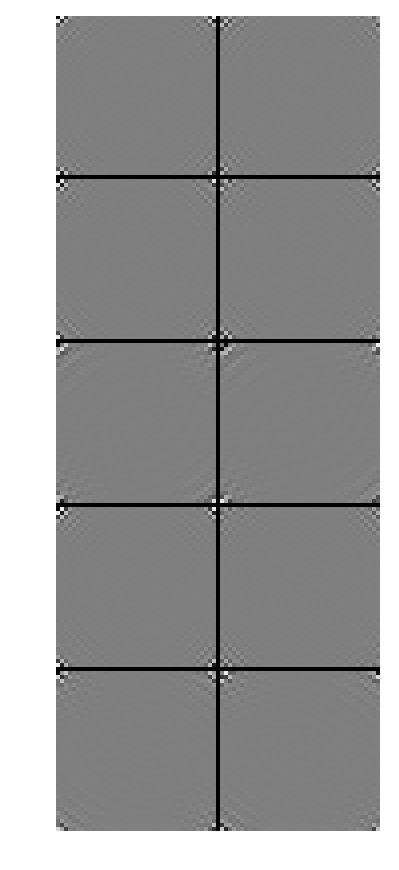

hfRel1Orig(N)(r)  (5, 2, 40, 40, 1)


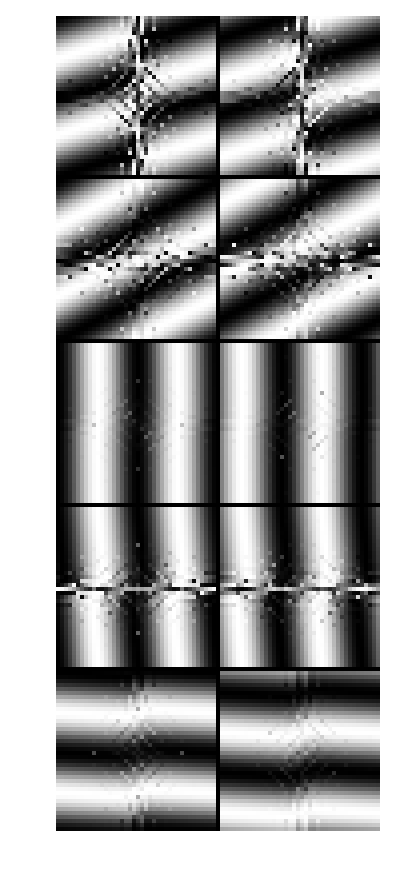

GT,Net,Blind(r)  (5, 10, 124, 40, 1)


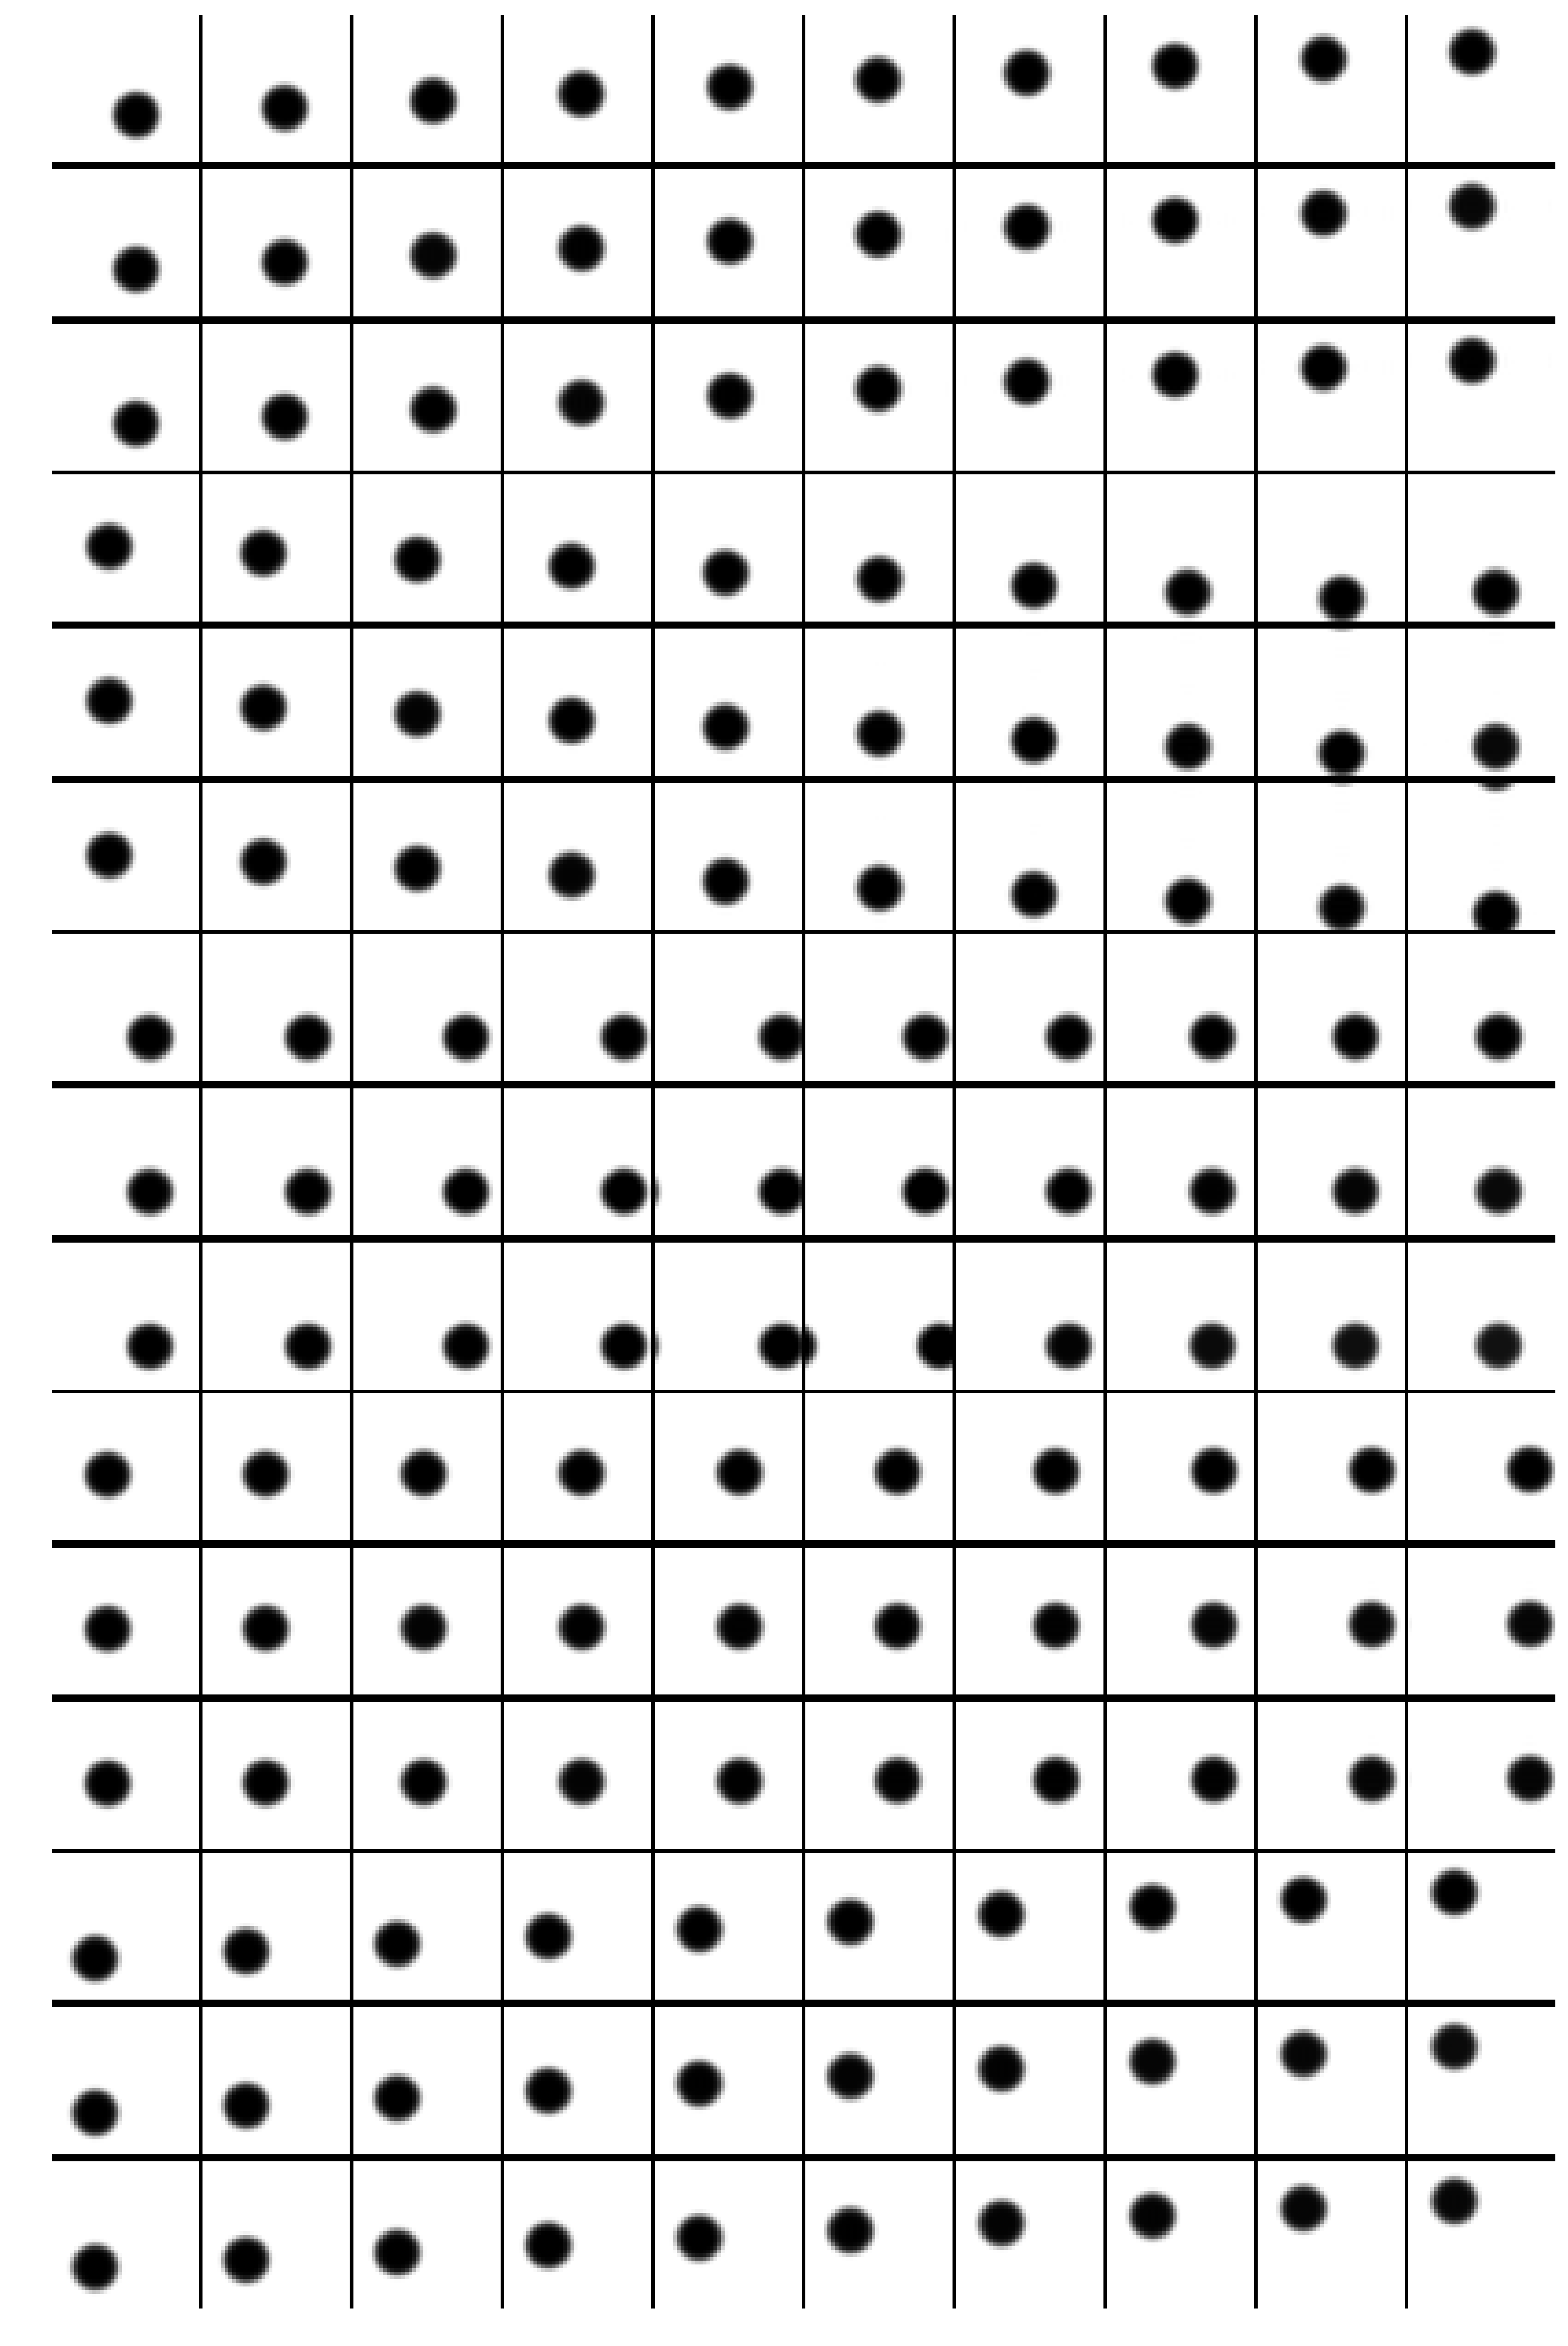

diffNet(N)(r)  (5, 8, 40, 40, 1)


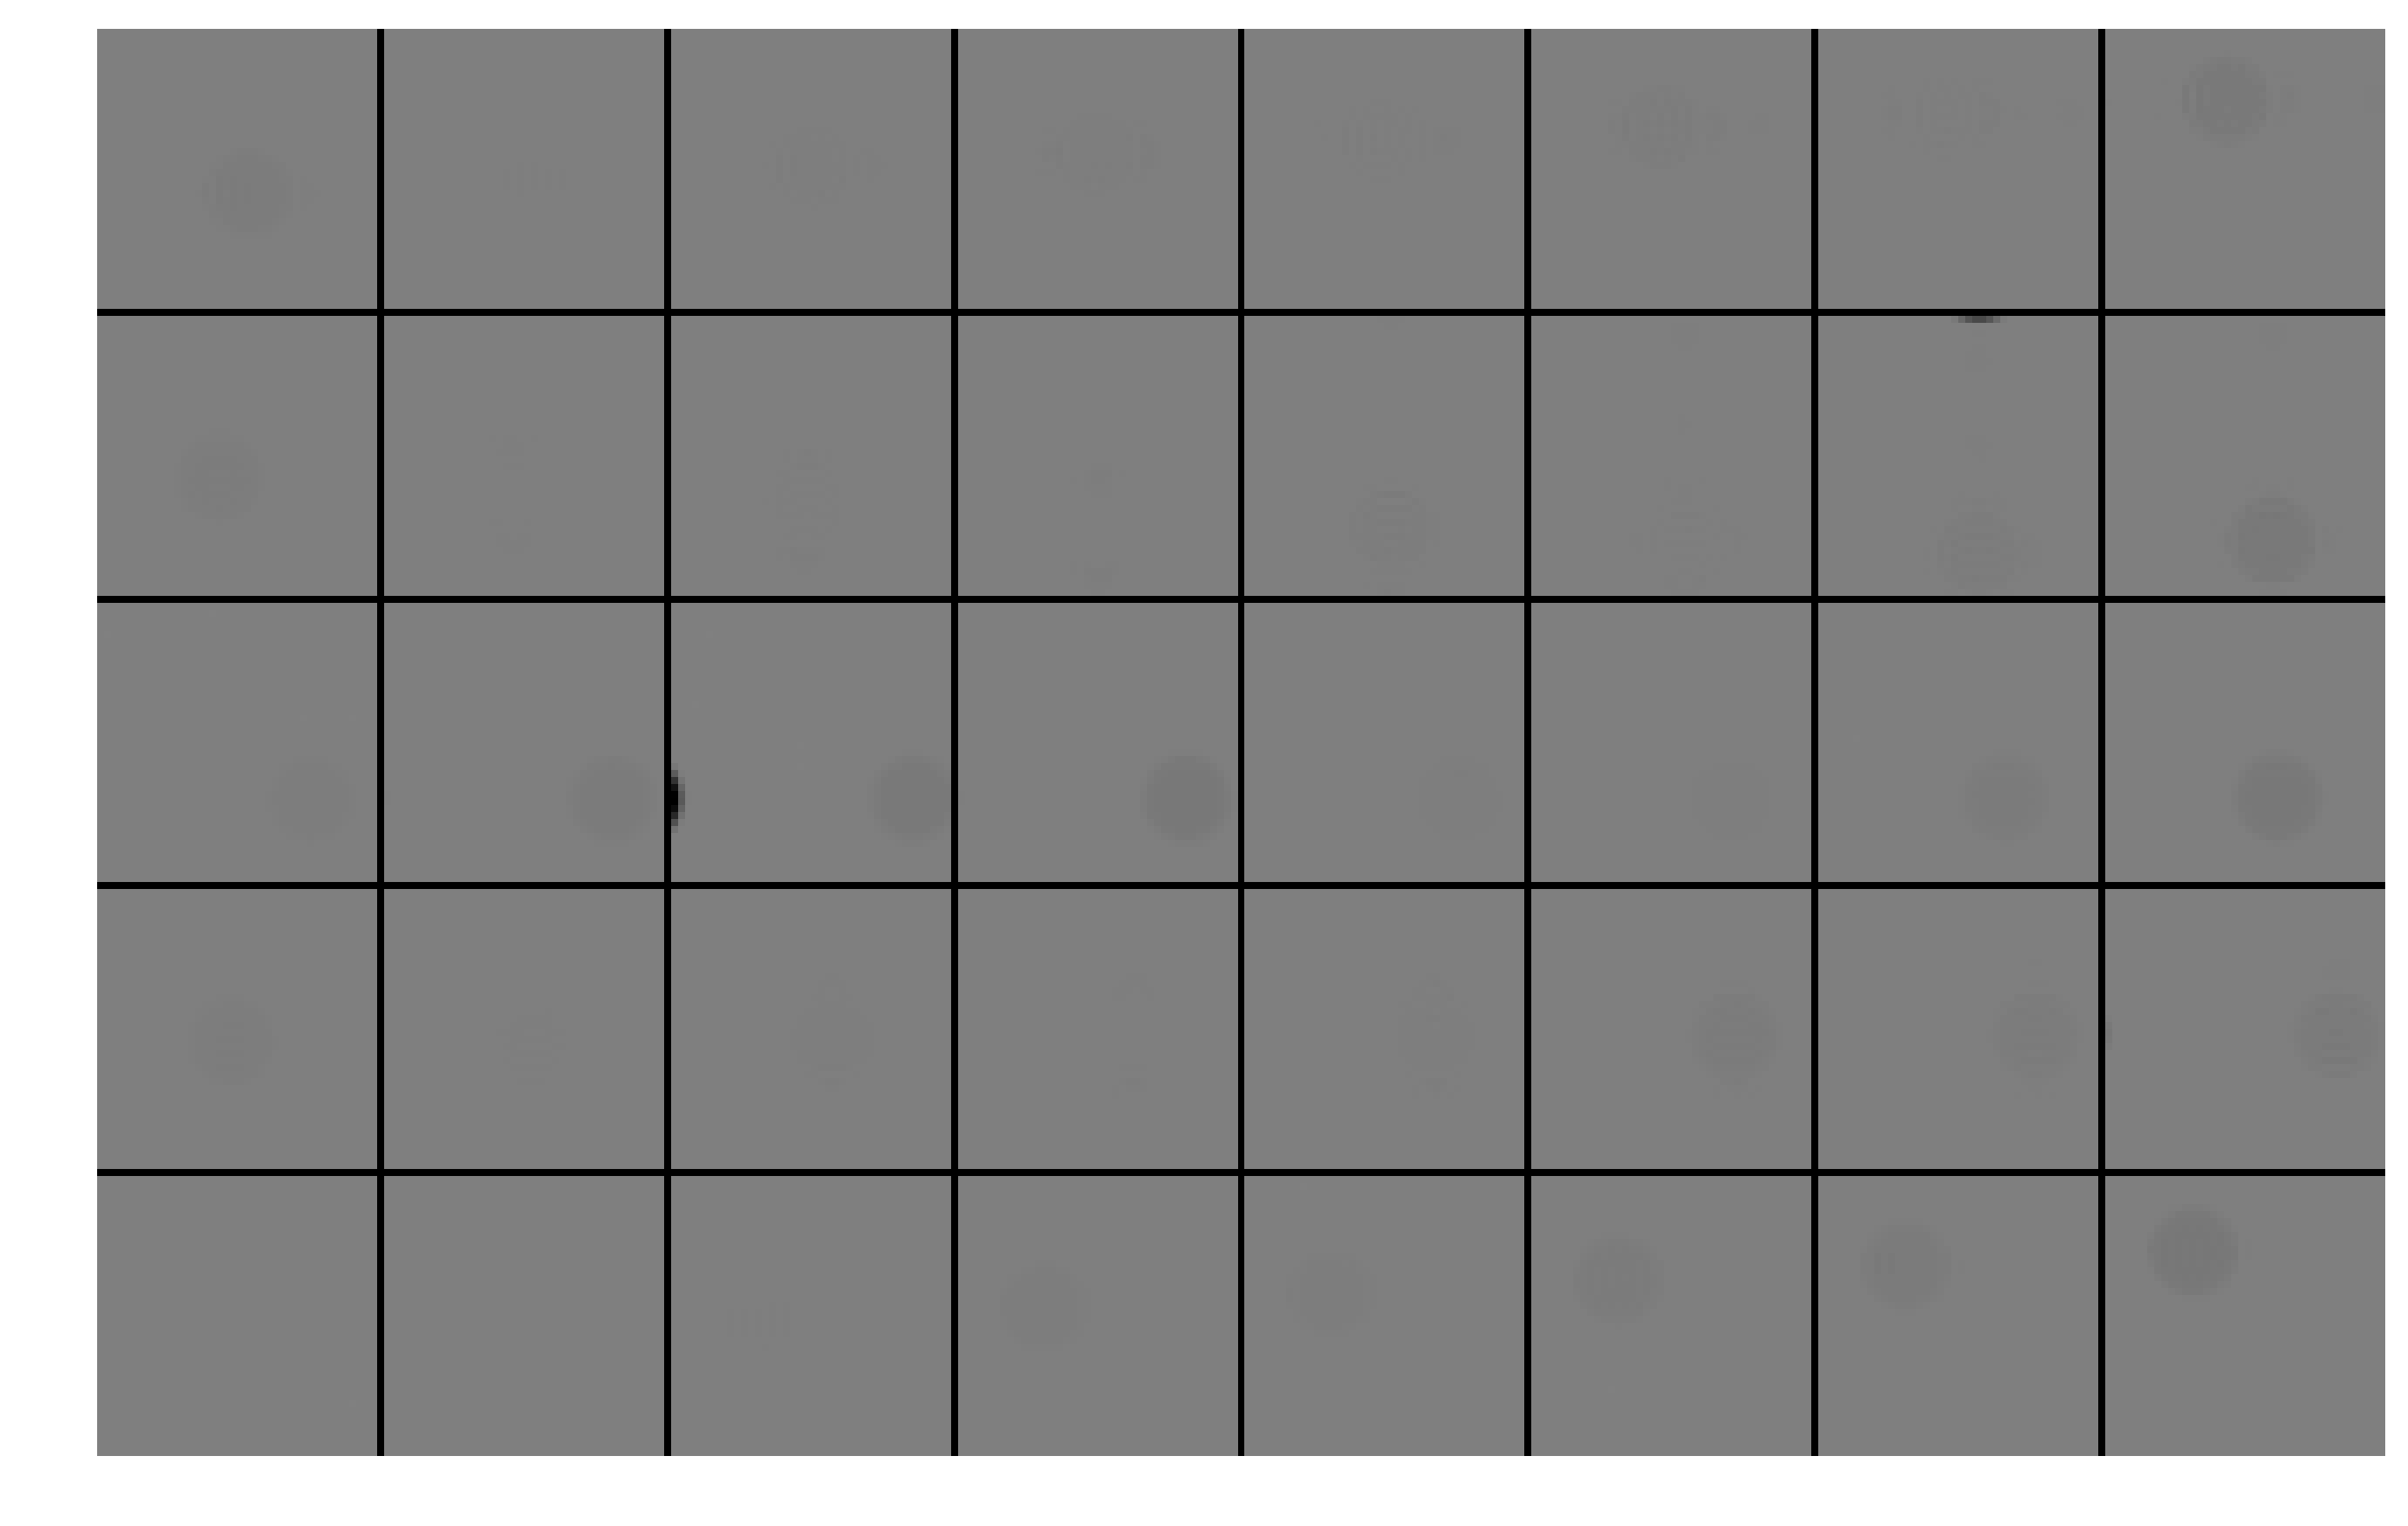

BCEMin= 0.036361201306675923  BCE= 0.042370760131000294  L1= 0.007105645555357384  L2= 0.0009269454184513871
This run of Conv-FFT-Denoising-2D ran for 0:01:07 and logs are available locally at: /home/user/hfarazi/.hyperdash/logs/conv-fft-denoising-2d/conv-fft-denoising-2d_2019-02-19t16-27-10-045322.log


BaseException: end here

In [7]:
save_code_backup()
if 'exp' in locals():
    exp.end()
exp = Experiment(theNotebook, capture_io=False)
if InfrencePhase:
    rand.seed(1);np.random.seed(1);t=0;infrenceRes=[]
pureFFT=False
normalizeFFT=True
delme=[]
checkParamChange()
saveEvery=1000

while t<=runs:
    if  t>0 and t%saveEvery==0:
        save_model("FFT"+str(t//saveEvery))
    if t==0 or True:
        dataSet = generateSeq(bs)
        if type(dataSet) is tuple:
            if(len(dataSet)==2):
                dataSet,ds_target = dataSet
            elif (len(dataSet)==3):
                dataSet,ds_target,regY = dataSet

        f0=np.copy(dataSet[:,0,:,:,0])
        f1=np.copy(dataSet[:,1,:,:,0])
        f2=np.copy(dataSet[:,2,:,:,0])

        dsBackup=np.copy(dataSet[:,:,:,:,:])

        s=torch.zeros((bs,resolution,resolution),dtype=torch.float).to(avDev)
        f=gaussian_noise(torch.from_numpy(f0).to(avDev),True,0.00)
        hf0 = torch.stack((f,s),dim=3)
        hf0 = torch.fft(hf0,2,normalized=normalizeFFT)
        hf0 = torch.cat((hf0,torch.zeros((bs,resolution,resolution,1),dtype=torch.float).to(avDev)),dim=3)

        f=gaussian_noise(torch.from_numpy(f1).to(avDev),True,0.00)
        hf1 = torch.stack((f,s),dim=3)
        hf1 = torch.fft(hf1,2,normalized=normalizeFFT)
        hf1 = torch.cat((hf1,torch.zeros((bs,resolution,resolution,1),dtype=torch.float).to(avDev)),dim=3)#torch.Size([bs, 40, 40, 3])
        
        f=gaussian_noise(torch.from_numpy(f2).to(avDev),True,0.00)
        hf2 = torch.stack((f,s),dim=3)
        hf2 = torch.fft(hf2,2,normalized=normalizeFFT)
        hf2 = torch.cat((hf2,torch.zeros((bs,resolution,resolution,1),dtype=torch.float).to(avDev)),dim=3)#torch.Size([bs, 40, 40, 3])

    
    hfRel1 = []
    hfRel2 = []
    resultT = []
    resultT.append(torch.ifft(hf0[:,:,:,0:2],2,normalized=normalizeFFT)[:,:,:,0])
    resultT.append(torch.ifft(hf1[:,:,:,0:2],2,normalized=normalizeFFT)[:,:,:,0])
    blindForcastingT = []
    blindForcastingT.append(resultT[0])
    blindForcastingT.append(resultT[1])
    if(pureFFT):
        resultT_fft = []
        resultT_fft.append(resultT[0])
        resultT_fft.append(resultT[1])
    
    agriBs=bs*resolution*resolution
    v1 = hf0.view(agriBs,3)
    v2 = hf1.view(agriBs,3)
    tmpAngle = [torch.bmm(v1.view(agriBs,1,3),v2.view(agriBs,3,1))[:,0,0]/((v1.norm(dim=1)*v2.norm(dim=1))+EPS),torch.cross(v1,v2,dim=1)[:,2]/((v1.norm(dim=1)*v2.norm(dim=1))+EPS)]
    tmpAngle = torch.stack(tmpAngle)
    hfRel1.append(tmpAngle)
        
    hfRel1Orig = torch.stack(hfRel1).permute(2,0,1).contiguous()
    
    if False:
        hfRel=net(hfRel1Orig.view(bs,-1))
    else:
        hfRel=hfRel1Orig.clone()
    
    hfRel = hfRel.view(bs,resolution,resolution,2)
    for s in range(2,seq_length):
        hfP = torch.stack((resultT[-1],torch.zeros((bs,resolution,resolution),dtype=torch.float).to(avDev)),dim=3)
        hfP = torch.fft(hfP,2,normalized=normalizeFFT)
        
        hfRelAgri=hfRel.view(agriBs,2)
        rot1 = [hfRelAgri[:,0],-hfRelAgri[:,1]]
        rot2 = [hfRelAgri[:,1],hfRelAgri[:,0]]
        rot1 = torch.stack(rot1,dim=1)
        rot2 = torch.stack(rot2,dim=1)
        rot = [rot1,rot2]
        rot = torch.stack(rot,dim=1)
        hfN=rot.bmm(hfP.view(agriBs,2,1)).squeeze(2)
        hfN = hfN.view(bs,resolution,resolution,2)
        blindForcastingT.append(torch.ifft(hfN,2,normalized=normalizeFFT)[:,:,:,0])
        netRes=net2((blindForcastingT[-1]-blindForcastingT[-2]).unsqueeze(1))#.round()
        
        hfRelM1 = torch.flip(hfRel,dims=[2])
        hfRelM2 = torch.flip(hfRel,dims=[1])
        hfRelM3 = torch.flip(hfRel,dims=[1,2])
        selectRel=torch.stack((hfRel,hfRelM1,hfRelM2,hfRelM3),dim=0)
        hfRel=torch.einsum("ij,ji...->i...",(netRes,selectRel))
        

        hfRelAgri=hfRel.view(agriBs,2)
        rot1 = [hfRelAgri[:,0],-hfRelAgri[:,1]]
        rot2 = [hfRelAgri[:,1],hfRelAgri[:,0]]
        rot1 = torch.stack(rot1,dim=1)
        rot2 = torch.stack(rot2,dim=1)
        rot = [rot1,rot2]
        rot = torch.stack(rot,dim=1)
        hfN=rot.bmm(hfP.view(agriBs,2,1)).squeeze(2)
        hfN = hfN.view(bs,resolution,resolution,2)
        #       resultT.append(torch.ifft(hfN,2,normalized=normalizeFFT)[:,:,:,0])
#       resultT.append(torch.ifft(hfN,2,normalized=normalizeFFT)[:,:,:,0]*net4(netRes).view(-1,1,1))
        resultT.append(net4(torch.ifft(hfN,2,normalized=normalizeFFT)[:,:,:,0].unsqueeze(1)).squeeze(1))
        
        if(pureFFT):
            hfP_fft = torch.stack((resultT_fft[-1],torch.zeros((bs,resolution,resolution),dtype=torch.float).to(avDev)),dim=3)
            hfP_fft = torch.fft(hfP_fft,2,normalized=normalizeFFT)
            hfRel1OrigAgri=hfRel1Orig.view(agriBs,2)
            rot1 = [hfRel1OrigAgri[:,0],-hfRel1OrigAgri[:,1]]
            rot2 = [hfRel1OrigAgri[:,1],hfRel1OrigAgri[:,0]]
            rot1 = torch.stack(rot1,dim=1)
            rot2 = torch.stack(rot2,dim=1)
            rot = [rot1,rot2]

            rot = torch.stack(rot,dim=1)
            hfN_fft=rot.bmm(hfP_fft.view(agriBs,2,1)).squeeze(2)
            hfN_fft = hfN_fft.view(bs,resolution,resolution,2)
            resultT_fft.append(torch.ifft(hfN_fft,2,normalized=normalizeFFT)[:,:,:,0])

        
    pre_frames_batch = torch.stack(resultT,dim=1).view(bs,seq_length,resolution,resolution,1)
    blind_frames_batch = torch.stack(blindForcastingT,dim=1).view(bs,seq_length,resolution,resolution,1)
#     pre_frames_batch.clamp_(0,1)
    if(pureFFT):
        out_fft = torch.stack(resultT_fft,dim=1).view(bs,seq_length,resolution,resolution,1)
        out_fft.clamp_(0,1)
    
    optimizers[0].zero_grad()
    batch_ds =  torch.Tensor(dsBackup).to(avDev)
    
    netOut =pre_frames_batch[:,2:,:,:,:]
    target = batch_ds[:,2:,:,:,:]
#     bceNetFull = critBCELogit(netOut,target)
    L1NetDiff = (netOut-target).abs()
    L1Net=L1NetDiff.mean()
    L2Net = critL2(netOut,target)
    bceNetFull =L2Net
    
    optimizers[0].step()
    if not InfrencePhase:
        (bceNetFull).backward()
        optimizers[0].step()
    netOut.clamp_(0,1)
    blind_frames_batch.clamp_(0,1)
    bceNet = critBCE(netOut,target)  
    bceMin=critBCE(target,target)


    if(pureFFT):
        bceFFT = critBCE(out_fft,target)  
        L1FFTDiff = (out_fft-target).abs()
        L1FFT = L1FFTDiff.mean() 
        L2FFT = critL2(out_fft,target)  

    if InfrencePhase:
        infrenceRes.append([bceMin.item(),bceNet.item(),L1Net.item(),L2Net.item()])
        
    print(t,"bceMin=","%0.5f" %bceMin.item()," bceNetFull=","%0.5f" %bceNetFull.item()," bceNet=","%0.5f" %bceNet.item()," L1Net=","%0.5f" %L1Net.item()," L2Net=","%0.5f" %L2Net.item())
    writer.add_scalar("bceNetFull",bceNetFull.item(),t);writer.add_scalar("bceNet",bceNet.item(),t);writer.add_scalar("L1Net",L1Net.item(),t);writer.add_scalar("L2Net",L2Net.item(),t);
    exp.metric("L2Net",L2Net.item())

 
    if(pureFFT):
        print(t,"bceFFT=","%0.5f" %bceFFT.item()," L1FFT=","%0.5f" %L1FFT.item()," L2FFT=","%0.5f" %L2FFT.item())
        writer.add_scalar("bceFFT",bceFFT.item(),t);writer.add_scalar("L1FFT",L1FFT.item(),t);writer.add_scalar("L2FFT",L2FFT.item(),t);

    checkParamChange()
    writer.add_scalar("params",paramCounter,t)
    if t%paintEvery==0:
        nParam=sum(p.numel() for p in net2.parameters() if p.requires_grad)+sum(p.numel() for p in net4.parameters() if p.requires_grad)
        print("Number of Parameters = ",nParam)
        print(t)
        r1=0
        r2=min(bs,5)
        showSeq(True,t,"locationBias",net2.locationBias.data.unsqueeze(-1),oneD=False,revert=True)
        showSeq(True,t,"hf0",hf0[r1:r2,:,:,0:2].permute(0,3,1,2).unsqueeze(-1).cpu().numpy(),oneD=False,revert=True,dpi=0.5)
        showSeq(True,t,"hf1",hf1[r1:r2,:,:,0:2].permute(0,3,1,2).unsqueeze(-1).cpu().numpy(),oneD=False,revert=True,dpi=0.5)
        showSeq(True,t,"hf2",hf2[r1:r2,:,:,0:2].permute(0,3,1,2).unsqueeze(-1).cpu().numpy(),oneD=False,revert=True,dpi=0.5)
        showSeq(True,t,"hfRel1Orig",hfRel1Orig.view(bs,resolution,resolution,2)[r1:r2,:,:,0:2].permute(0,3,1,2).unsqueeze(-1).cpu().numpy(),oneD=False,revert=True,dpi=0.5)
        if(pureFFT):
            showSeq(False,t,"net,fft,GT",pre_frames_batch.detach()[r1:r2].cpu().numpy(),[out_fft.detach()[r1:r2].cpu().numpy(),batch_ds.cpu().numpy()[r1:r2]],oneD=dimention==1,revert=True)
            showSeq(True,t,"diffNet,diff_FFT",L1NetDiff.detach()[r1:r2].cpu().numpy(),[L1FFTDiff.detach()[r1:r2].cpu().numpy()],oneD=dimention==1,revert=True)
        else:
            showSeq(False,t,"GT,Net,Blind",batch_ds.cpu().numpy()[r1:r2],[pre_frames_batch.detach()[r1:r2].cpu().numpy(),blind_frames_batch.detach()[r1:r2].cpu().numpy()],oneD=dimention==1,revert=True)
            showSeq(True,t,"diffNet",L1NetDiff.detach()[r1:r2].cpu().numpy(),oneD=dimention==1,revert=True)
    t=t+1
    if(InfrencePhase and t>runs):
        infrenceRes=np.array(infrenceRes)
        print("BCEMin=",infrenceRes[:,0].mean()," BCE=",infrenceRes[:,1].mean()," L1=",infrenceRes[:,2].mean()," L2=",infrenceRes[:,3].mean())
        exp.end()
        raise BaseException("end here")
